In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

LOCAL = True
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    RE = os.path.join(PATH, "results")
    CONFIG_NAME="config.local.neuron.mpra.ini"
    RE_MAPS = os.path.join(RE, "enh_maps")
else:
    PATH="/wynton/group/ahituv/biomarin/data"
    RE = "/wynton/group/ahituv/biomarin/results"
    RE_MAPS = os.path.join(RE, "enh_maps")
    CONFIG_NAME="config.neuron.mpra.orig.ini"

# write file for nominations
NOMS = os.path.join(PATH, "GABA_GLUT_DF.for.noms.tsv")

import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
config, cfn = crw.read(CONFIG_NAME)

section = 'lib2'
crw.check(config, section)

In [3]:
if "fasta" not in list(config[section]):  # write files to config

    MPRA = os.path.join(PATH, "delta_rank.csv")

    FASTA = os.path.join(PATH, "library_2", "Design",
                         "biomarin-lib2-hg38-final.fasta")
    META_DATA = os.path.join(PATH, "lib2.meta_data.tsv")
    TILE_BED = os.path.join(PATH, "lib2.processed.bed")
    ENH_BED = os.path.join(PATH, 'lib2.processed.merged.bed')
    GREAT_GENE_TSV = os.path.join(PATH, "GREAT", f"region2gene_lib2hg38.tsv")
    DELTA_ACTIVITY = os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
    DELTA_ACTIVITY_Z = os.path.join(
        PATH, "deltaMPRA.gaba.minus.glut.zscore.tsv")
    SIG_ACTIVITY_Z = os.path.join(PATH, "WilcoxonSig.gaba.glut.zscore.tsv")
    VISTA = os.path.join(PATH, "vista.lib2.tiles.bed")

    # delta MPRA activity
    config[section]["delta.mpra_richa"] = MPRA
    config[section]["delta.mpra_centered"] = DELTA_ACTIVITY
    config[section]["delta.mpra_centeredz"] = DELTA_ACTIVITY_Z

    config[section]["fasta"] = FASTA

    # genome coordinates
    config[section]["tile_bed"] = TILE_BED
    config[section]["enh_bed"] = ENH_BED

    # GREAT
    config[section]["great_nearest"] = GREAT_GENE_TSV

    # meta_data
    config[section]["metadata"] = META_DATA

    # significance GABA v. GLUT
    config[section]["sig-wilcoxon"] = SIG_ACTIVITY_Z

    # vista
    config[section]["vista"] = VISTA
    crw.write(config, cfn)

else:
    MPRA = config[section]["delta.mpra_richa"]
    DELTA_ACTIVITY = config[section]["delta.mpra_centered"]
    DELTA_ACTIVITY_Z = config[section]["delta.mpra_centeredz"]

    FASTA = config[section]["fasta"]

    TILE_BED = config[section]["tile_bed"]
    ENH_BED = config[section]["enh_bed"]

    GREAT_GENE_TSV = config[section]["great_nearest"]
    META_DATA = config[section]["metadata"]

    SIG_ACTIVITY_Z = config[section]["sig-wilcoxon"]
    VISTA = config[section]["vista"]
    

In [4]:
meta = pd.read_csv(META_DATA, sep='\t')
delta = pd.read_csv(DELTA_ACTIVITY, sep='\t')

len(set(meta["enh.id"]))

1828

# load MPRA data

In [5]:
mpra = pd.read_csv(MPRA)
#mpra = mpra.rename(columns ={"delta.gaba-glut":"delta"})
print(mpra.shape)
mpra.head()

(35371, 5)


,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10339772-10340042,-1.602773,0.466691,-2.069465,1.0
1,chr6:154127563-154127833,-0.460660,1.393760,-1.854420,2.0
2,chr4:93216597-93216867,-1.373226,0.426283,-1.799509,3.0
3,chr9:127735295-127735565,-0.784093,1.010851,-1.794944,4.0
4,chr1:31376876-31377146,-0.500106,1.291683,-1.791789,5.0


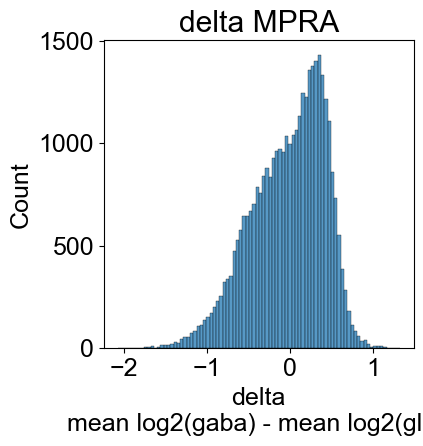

In [6]:
fig, ax = plt.subplots(figsize=(4,4))
sns.histplot(mpra["delta"])
ax.set(title="delta MPRA",
      xlabel="delta\nmean log2(gaba) - mean log2(glut)")
plt.savefig(os.path.join(RE, "deltas.pdf"), bbox_inches="tight")

In [7]:
mpra["delta"].describe()

count    35371.000000
mean        -0.023292
std          0.442305
min         -2.069465
25%         -0.325397
50%          0.043795
75%          0.324542
max          1.319865
Name: delta, dtype: float64

# evaluate GREAT

- get nearby coordinates using GREAT nearest 2 gene function

## load great annotations

In [8]:
GREAT_GENE = os.path.join(os.path.split(MPRA)[0], "GREAT", f"region2gene_lib2hg38.txt")

locus_dict = {}
with open(GREAT_GENE, "r") as reader:
    for line in reader:
        if "#" not in line and line !="\n":
            
            locus, genes = line.strip("\n").split("\t")  # split on tab to get gene name

            info = [locus]
            
            for n, i in enumerate(genes.split(",")):
                if i != "NONE":
                    gene, dist = i.strip(" ").split(" ")
                    dist = dist.strip("()")
                else:
                    gene, dist = "na", "na"
                
                locus_dict[f'{locus}-{n}'] = [locus, gene, dist]


vstack = np.vstack(locus_dict.values())

great = pd.DataFrame(vstack)
great.columns = ["coor", "gene", 'dist']
great = great.loc[great.dist!="na"]  # remove any elements w/ no genes
great.head()

,coor,gene,dist
0,chr1:101316025-101316295,S1PR1,+79272
1,chr1:101316025-101316295,OLFM3,+530813
2,chr1:101316045-101316315,S1PR1,+79292
3,chr1:101316045-101316315,OLFM3,+530793
4,chr1:101316065-101316335,S1PR1,+79312


# add GREAT annotations to fasta meta data

In [9]:
enh = pd.merge(great, meta, how="right")

# rename columns for merging with MPRA data
enh = enh.rename(columns ={"start":"start.tile",
                           "end":"end.tile"})

enh.head()

,coor,gene,dist,name,sequence,bkgd,72h,ctrl,cl,top_bottom,strand,#chr,start.tile,end.tile,enh.id,enh.name,tile.order
0,chr1:10057-10327,NaN,NaN,chr1:10057-10327,AGGACCGGATCAACTCCCTAACCCTAACCCTAACCCTAACCCTAAC...,False,NaN,NaN,NaN,NaN,+,chr1,10057,10327,chr1:10057-10563,enh.1,0.0
1,chr1:10077-10347,NaN,NaN,chr1:10077-10347,AGGACCGGATCAACTCTAACCCTAACCCTAACCCTAACCCTAACCC...,False,NaN,NaN,NaN,NaN,+,chr1,10077,10347,chr1:10057-10563,enh.1,1.0
2,chr1:10097-10367,NaN,NaN,chr1:10097-10367,AGGACCGGATCAACTAACCCTAACCCAACCCTAACCCTAACCCTAA...,False,NaN,NaN,NaN,NaN,+,chr1,10097,10367,chr1:10057-10563,enh.1,2.0
3,chr1:10117-10387,NaN,NaN,chr1:10117-10387,AGGACCGGATCAACTCCTAACCCTAACCCTAACCCTAACCCTAACC...,False,NaN,NaN,NaN,NaN,+,chr1,10117,10387,chr1:10057-10563,enh.1,3.0
4,chr1:10133-10403,NaN,NaN,chr1:10133-10403,AGGACCGGATCAACTACCCTAACCCTAACCCCTAACCCTAACCCTA...,False,NaN,NaN,NaN,NaN,+,chr1,10133,10403,chr1:10057-10563,enh.1,4.0


# add MPRA

In [10]:
enh = pd.merge(enh, mpra, how="left", left_on="name",
               right_on="name").drop_duplicates()
print(enh.shape)
enh.head()

(72603, 21)


,coor,gene,dist,name,sequence,bkgd,72h,ctrl,cl,top_bottom,...,#chr,start.tile,end.tile,enh.id,enh.name,tile.order,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10057-10327,NaN,NaN,chr1:10057-10327,AGGACCGGATCAACTCCCTAACCCTAACCCTAACCCTAACCCTAAC...,False,NaN,NaN,NaN,NaN,...,chr1,10057,10327,chr1:10057-10563,enh.1,0.0,NaN,NaN,NaN,NaN
1,chr1:10077-10347,NaN,NaN,chr1:10077-10347,AGGACCGGATCAACTCTAACCCTAACCCTAACCCTAACCCTAACCC...,False,NaN,NaN,NaN,NaN,...,chr1,10077,10347,chr1:10057-10563,enh.1,1.0,NaN,NaN,NaN,NaN
2,chr1:10097-10367,NaN,NaN,chr1:10097-10367,AGGACCGGATCAACTAACCCTAACCCAACCCTAACCCTAACCCTAA...,False,NaN,NaN,NaN,NaN,...,chr1,10097,10367,chr1:10057-10563,enh.1,2.0,NaN,NaN,NaN,NaN
3,chr1:10117-10387,NaN,NaN,chr1:10117-10387,AGGACCGGATCAACTCCTAACCCTAACCCTAACCCTAACCCTAACC...,False,NaN,NaN,NaN,NaN,...,chr1,10117,10387,chr1:10057-10563,enh.1,3.0,NaN,NaN,NaN,NaN
4,chr1:10133-10403,NaN,NaN,chr1:10133-10403,AGGACCGGATCAACTACCCTAACCCTAACCCCTAACCCTAACCCTA...,False,NaN,NaN,NaN,NaN,...,chr1,10133,10403,chr1:10057-10563,enh.1,4.0,NaN,NaN,NaN,NaN


In [11]:
enh = pd.merge(enh, delta, how="left", left_on ="name", right_on="name").drop_duplicates()

enh.shape

(72603, 27)

In [15]:
enh.drop_duplicates().shape

(72603, 27)

In [19]:
enh.loc[(enh["enh.name"]=='enh.74') & (enh["tile.order"]==22)]

,coor,gene,dist,name,sequence,bkgd,72h,ctrl,cl,top_bottom,...,gaba_log2_mean,glut_log2_mean,delta,delta_rank,gaba-label,glut-label,celltype_dif,gaba,glut,delta.gaba-glut
977,chr1:22710242-22710512,EPHB2,-588,chr1:22710242-22710512,AGGACCGGATCAACTCCCGGTGCCTGGGAAAGCCGCCTGTTTTGTT...,False,NaN,NaN,NaN,NaN,...,0.766423,0.13276,0.633663,34359.0,False,False,False,0.766423,0.13276,0.633663
978,chr1:22710242-22710512,C1QB,+57188,chr1:22710242-22710512,AGGACCGGATCAACTCCCGGTGCCTGGGAAAGCCGCCTGTTTTGTT...,False,NaN,NaN,NaN,NaN,...,0.766423,0.13276,0.633663,34359.0,False,False,False,0.766423,0.13276,0.633663


# add significance data

In [20]:
sig_reps= pd.read_csv(SIG_ACTIVITY_Z, sep='\t')
print(sig_reps.shape)
sig_reps.head()

(34403, 11)


,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
0,Negative-72hr_top_107,-2.112902,-1.789124,-1.770109,-1.424562,-1.556022,-1.169788,0.033115,False,0.109027,0.962468
1,Negative-72hr_top_149,-2.058643,-1.985698,-1.764917,-1.248358,-1.431705,-1.954289,0.196918,False,0.318473,0.496928
2,Negative-72hr_top_187,-1.888327,-1.489358,-2.018197,-1.810824,-2.665386,-1.203121,0.850285,False,0.894914,0.048219
3,Negative-72hr_top_195,-1.241767,-1.058938,-1.592222,-1.247204,-0.628020,-0.730500,0.160712,False,0.277433,0.556842
4,Negative-72hr_top_98,-3.667243,-2.985988,-3.083059,-1.519082,-3.209065,-1.625178,0.164496,False,0.281737,0.550156


In [21]:
sig_reps.groupby(["fdr_bool"])["name"].count()

fdr_bool
False    30779
True      3624
Name: name, dtype: int64

## example of significant, non-significant reps

In [22]:
sig_reps.sample(n=3)

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
5787,chr12:8180086-8180356,0.883256,0.994702,1.093357,2.195072,1.642934,1.844383,0.019951,False,0.085090,1.070122
16574,chr20:19508543-19508813,-0.754566,-0.728299,-0.836495,0.005993,1.132942,0.156075,0.075075,False,0.172249,0.763845
26895,chr5:175533977-175534247,-0.258971,-0.466412,-0.655991,-0.835631,-0.475196,-0.102349,0.967577,False,0.978527,0.009427


In [23]:
enh= pd.merge(enh, sig_reps, how="left").drop_duplicates()
enh["sig"] = enh["fdr"].apply(lambda x: True if x<0.05 else False)

enh["gaba"] = enh[["gaba_1", "gaba_2", "gaba_3"]].mean(axis=1)

enh["glut"] = enh[["glut_1", "glut_2", "glut_3"]].mean(axis=1)
enh["delta.gaba-glut"] = enh["gaba"]-enh["glut"]
enh.head()

,coor,gene,dist,name,sequence,bkgd,72h,ctrl,cl,top_bottom,...,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr,sig
0,chr1:10057-10327,NaN,NaN,chr1:10057-10327,AGGACCGGATCAACTCCCTAACCCTAACCCTAACCCTAACCCTAAC...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,chr1:10077-10347,NaN,NaN,chr1:10077-10347,AGGACCGGATCAACTCTAACCCTAACCCTAACCCTAACCCTAACCC...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,chr1:10097-10367,NaN,NaN,chr1:10097-10367,AGGACCGGATCAACTAACCCTAACCCAACCCTAACCCTAACCCTAA...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,chr1:10117-10387,NaN,NaN,chr1:10117-10387,AGGACCGGATCAACTCCTAACCCTAACCCTAACCCTAACCCTAACC...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,chr1:10133-10403,NaN,NaN,chr1:10133-10403,AGGACCGGATCAACTACCCTAACCCTAACCCCTAACCCTAACCCTA...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


## plot sig deltas

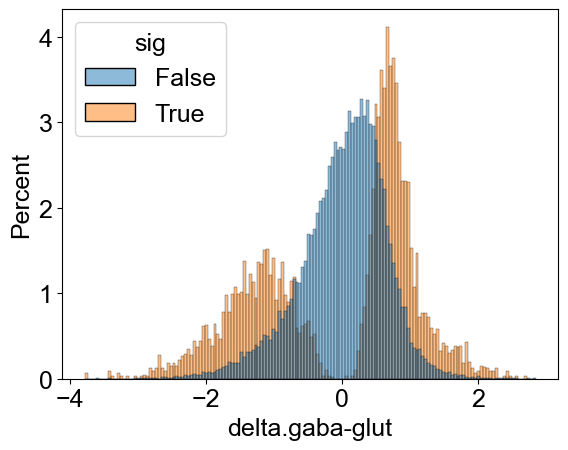

In [24]:
sns.histplot(x="delta.gaba-glut", data=enh, hue="sig", stat="percent", common_norm=False)
out = os.path.join(RE, "delta.dist.sig.only.pdf")
plt.savefig(out, bbox_inches='tight')

## combine significant ttest and celltype_dif (categorical) labels

In [25]:
enh["sig_n_dif"] = False
#enh.loc[(enh["sig"]==True) & (enh["celltype_dif"]==True), "sig_n_dif"]=True
enh.loc[(enh["fdr_bool"]==True) & (enh["celltype_dif"]==True), "sig_n_dif"]=True

# print counts
print(enh[["name", "sig"]].drop_duplicates().groupby("sig")['name'].count())
print(enh[["name", "celltype_dif"]].drop_duplicates().groupby("celltype_dif")['name'].count())
print(enh[["name", "sig_n_dif"]].drop_duplicates().groupby("sig_n_dif")['name'].count())

sig
False    40420
True      3624
Name: name, dtype: int64
celltype_dif
False    28113
True      6290
Name: name, dtype: int64
sig_n_dif
False    42848
True      1196
Name: name, dtype: int64


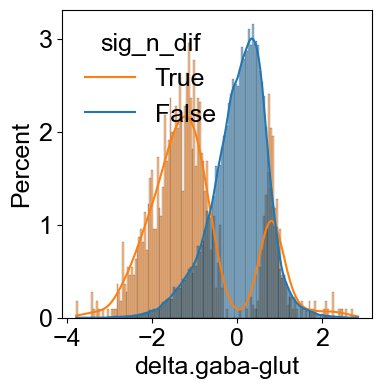

In [26]:
# histogram sig_n_dif
fig, ax=plt.subplots(figsize=(4,4))
sns.histplot(x="delta.gaba-glut", data=enh, hue="sig_n_dif", kde=True, stat="percent", common_norm=False)
ax.legend([True, False], title="sig_n_dif", frameon=False)
out = os.path.join(RE,"delta.distribution.sig_n_dif.pdf")
plt.savefig(out, bbox_inches='tight')

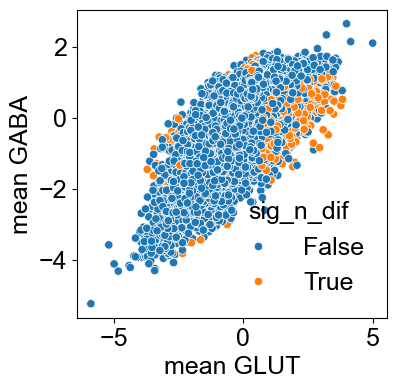

In [27]:
# effect sizes of sig and dif
fig, ax= plt.subplots(figsize=(4,4))
y="gaba" 
x="glut" 
data=enh 
hue="sig_n_dif"
sns.scatterplot(x=x, y=y, data=data, hue=hue)
out = os.path.join(RE, "cell-type-dif.scatter.pdf")
ax.set(xlabel="mean GLUT", 
      ylabel="mean GABA")
ax.legend(#[True, False], 
          title=hue, frameon=False)
plt.savefig(out, bbox_inches='tight')

## bootstrap effect size from full distribution
- generate if not written to config already

In [28]:
if "bsdelta.n" not in list(config[section]):

    # set up and bootstrap delta effect sizes
    BS = 1000
    bs_results975, bs_results025 = [], []
    
    for i in np.arange(BS):

        # bootstrap from entire MPRA distribution
        bsdf = enh[["coor", "gaba", "glut", "delta.gaba-glut"]
                   ].drop_duplicates().copy()
        
        # sample delta scores with replacement
        sample = bsdf["delta.gaba-glut"].sample(n=bsdf.shape[0], replace=True)

        # bootstrap 95% confidence intervals
        bs_results975.append(sample.quantile(0.975))
        bs_results025.append(sample.quantile(0.025))

    BS975_MED, BS025_MED= np.median(bs_results975), np.median(bs_results025)

    # write results to config
    config[section]["bsdelta.n"]= str(BS)
    config[section]["bs975.delta.1000.median"] = str(BS975_MED)
    config[section]["bs025.delta.1000.median"] = str(BS025_MED)
    crw.write(config, cfn)

else: # pull from config
    BS975_MED =  float(config[section]["bs975.delta.1000.median"])
    BS025_MED =  float(config[section]["bs025.delta.1000.median"])
    BS = int(config[section]["bsdelta.n"])

# print boostrated confidence intervals    
print("bootstrapped median 97.5% and 2.5% ci's",
      BS975_MED, BS025_MED, BS)

bootstrapped median 97.5% and 2.5% ci's 1.1605280864716692 -1.6173792611084172 1000


### write bootstrap to config 

### keep only delta values more extreme than bootstrapped delta distribution

In [29]:
# annotate enhancer tiles that surpass the CI
enh["bs"] = enh['delta.gaba-glut'].apply(lambda x: True if x >  BS975_MED or x < BS025_MED else False)

### plot bs values w full effectsize distribution

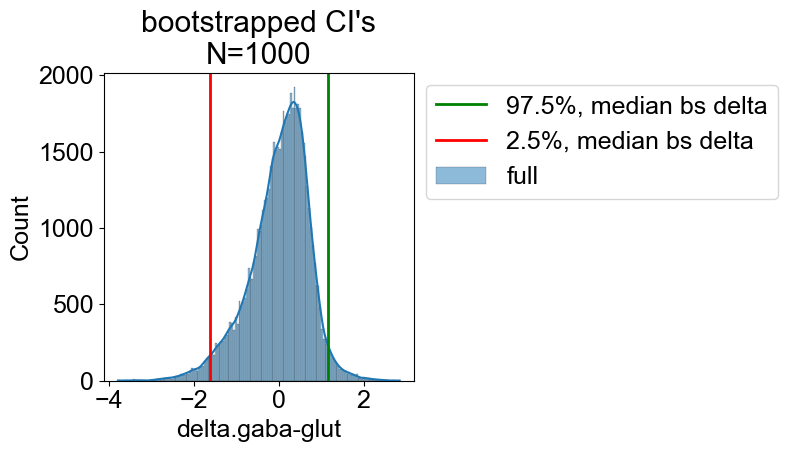

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))

# plot delta distribution
sns.histplot(enh["delta.gaba-glut"], label=f"full", kde=True)


# plot BS CIs
ax.axvline(BS975_MED,
           label=f"97.5%, median bs delta", color="green", lw=2)
ax.axvline(BS025_MED,
           label=f"2.5%, median bs delta", color="red", lw=2)

# get rid of legend
ax.legend(bbox_to_anchor=(1,1))

# set labels
ax.set(xlabel="delta.gaba-glut", title=f"bootstrapped CI's\nN={BS}")

# save
out = os.path.join(RE, "bs-deltas.pdf")
plt.savefig(out, bbox_inches='tight')

### plot bs values with only significant and difference elements

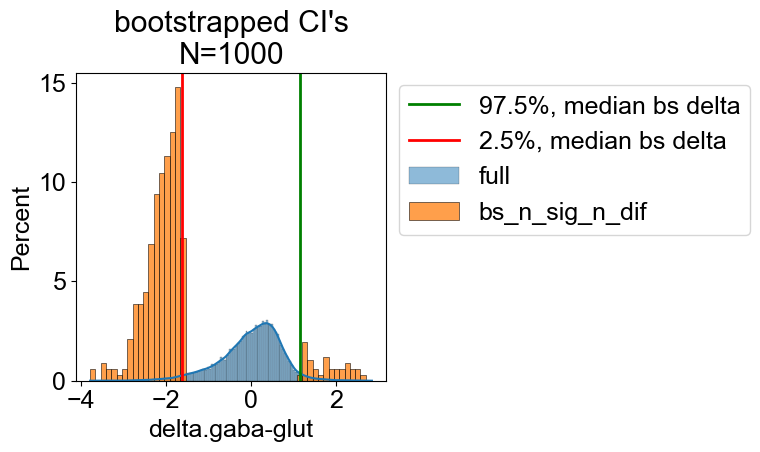

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))

# plot delta distribution
sns.histplot(enh["delta.gaba-glut"], label=f"full", stat="percent", kde=True)
sns.histplot(enh.loc[(enh["sig_n_dif"] == True) &
                     (enh["bs"] == True),
                     "delta.gaba-glut"],
             label=f"bs_n_sig_n_dif",
             stat="percent", kde=False
             )

# plot BS CIs
ax.axvline(BS975_MED,
           label=f"97.5%, median bs delta", color="green", lw=2)
ax.axvline(BS025_MED,
           label=f"2.5%, median bs delta", color="red", lw=2)

# get rid of legend
ax.legend(bbox_to_anchor=(1,1))

# set labels
ax.set(xlabel="delta.gaba-glut", title=f"bootstrapped CI's\nN={BS}")

# save
out = os.path.join(RE, "bs-deltas.bs_n_sig_n_dif.pdf")
plt.savefig(out, bbox_inches='tight')

## add direction to  delta values

In [32]:
def responseDirection(df):
    col = "direction"
    df[col] = None
    inspection_cols = [col,
                       'delta.gaba-glut',
                       "gaba",
                       "glut",
                       'gaba_1',
                       'gaba_2',
                       'gaba_3',
                       'glut_1',
                       'glut_2',
                       'glut_3']

    df.loc[(df['gaba'] < 0)
           & (df['glut'] < 0)
           & (df["delta.gaba-glut"] < 0),
           col] = "both negative, GABA<GLUT"  # GABA is more silencing than glut

    df.loc[(df['gaba'] < 0)
           & (df['glut'] < 0)
           & (df["delta.gaba-glut"] > 0),
           col] = "both negative, GLUT<GABA"  # GLUT is more silencing than GABA

    df.loc[(df['gaba'] > 0)
           & (df['glut'] > 0)
           & (df["delta.gaba-glut"] < 0),
           col] = "both positive GLUT>GABA"  # GLUT is more active than GABA

    df.loc[(df['gaba'] > 0)
           & (df['glut'] > 0)
           & (df["delta.gaba-glut"] > 0),
           col] = "both positive GABA>GLUT"  # GABA is more active than GLUT

    df.loc[(df['gaba'] < 0)
           & (df['glut'] > 0)
           & (df["delta.gaba-glut"] < 0),
           col] = "positive GLUT>negative GABA"  # GLUT is active, GABA is not

    df.loc[(df['gaba'] > 0)
           & (df['glut'] < 0)
           & (df["delta.gaba-glut"] > 0),
           col] = "positive GABA>negative GLUT"  # GABA is active, glut is not.

    print("unlabeled", df.loc[df[col].isna(), inspection_cols].shape[0])

    return df.drop_duplicates()

In [33]:
# add direction annotations based on sign of mean GABA, GLUT activity value
enh = responseDirection(enh)

unlabeled 9658


In [34]:
#set(enh.loc[enh["direction"].isna()==True, "name"])

enh.loc[enh["name"] == "chr17:43530167-43530437"]

enh.loc[enh["name"].str.contains("Background")]

,coor,gene,dist,name,sequence,bkgd,72h,ctrl,cl,top_bottom,...,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr,sig,sig_n_dif,bs,direction
6766,chr1:244100624-244100893,NaN,NaN,Background seq2 chr1:244100624-244100893:+|Pos...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,None
6767,chr1:244100624-244100893,NaN,NaN,Background seq2 chr1:244100624-244100893:+|Pos...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,None
6768,chr1:244100624-244100893,NaN,NaN,Background seq2 chr1:244100624-244100893:+|Pos...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,None
6769,chr1:244100624-244100893,NaN,NaN,Background seq2 chr1:244100624-244100893:+|Pos...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,None
6770,chr1:244100624-244100893,NaN,NaN,Background seq2 chr1:244100624-244100893:+|Pos...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70969,chr::-1--1,NaN,NaN,"Background seq1 72hr_top_98|Pos1:115,Pos2:155|...",AGGACCGGATCAACTCTACTCCTGTGCGGGGTTAAGACCTAAGGAA...,True,NaN,NaN,NaN,top,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,None
70970,chr::-1--1,NaN,NaN,"Background seq1 72hr_top_98|Pos1:115,Pos2:155|...",AGGACCGGATCAACTCTACTCCTGTGCGGGGTTAAGACCTAAGGAA...,True,NaN,NaN,NaN,top,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,None
70971,chr::-1--1,NaN,NaN,"Background seq1 72hr_top_98|Pos1:115,Pos2:155|...",AGGACCGGATCAACTCTACTCCTGTGCGGGGTTAAGACCTAAGGAA...,True,NaN,NaN,NaN,top,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,None
70972,chr::-1--1,NaN,NaN,"Background seq1 72hr_top_98|Pos1:115,Pos2:155|...",AGGACCGGATCAACTCTACTCCTGTGCGGGGTTAAGACCTAAGGAA...,True,NaN,NaN,NaN,top,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,None


## significance - p, shuffled, AND bs

In [35]:
enh["sig_n_dif_n_bs"] = False
enh.loc[(enh["sig_n_dif"]==True) & (enh["bs"]==True), "sig_n_dif_n_bs"] = True

cols = ["bs", 'sig',
        'direction',
        'sig_n_dif', "sig_n_dif_n_bs","name"]

# look at counts
enh[cols].drop_duplicates().groupby(["bs", 'sig_n_dif_n_bs',
                                     'direction'
                                     ])["name"].count()

bs     sig_n_dif_n_bs  direction                  
False  False           both negative, GABA<GLUT        6684
                       both negative, GLUT<GABA        3913
                       both positive GABA>GLUT        11543
                       both positive GLUT>GABA         4892
                       positive GABA>negative GLUT     3313
                       positive GLUT>negative GABA     2341
True   False           both negative, GABA<GLUT          62
                       both negative, GLUT<GABA         267
                       both positive GABA>GLUT            7
                       both positive GLUT>GABA          125
                       positive GABA>negative GLUT      550
                       positive GLUT>negative GABA      352
       True            both negative, GABA<GLUT           3
                       both negative, GLUT<GABA          19
                       both positive GABA>GLUT            7
                       both positive GLUT>GABA   

In [36]:
enh[cols].drop_duplicates().groupby(["bs", 'sig_n_dif_n_bs',
                                     ])["name"].count()

bs     sig_n_dif_n_bs
False  False             42327
True   False              1363
       True                354
Name: name, dtype: int64

### inspect each of the delta calls visually. 
- note there is no case where Glut is positive and GABA is negative. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


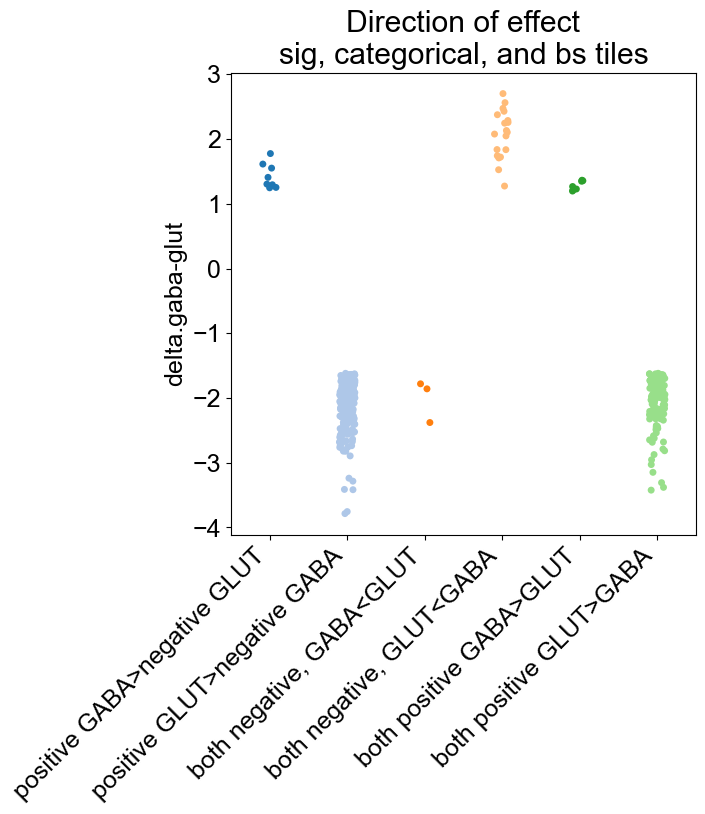

In [37]:
# order
order = ['positive GABA>negative GLUT',
         'positive GLUT>negative GABA',
         'both negative, GABA<GLUT',
         'both negative, GLUT<GABA',
         'both positive GABA>GLUT',
         'both positive GLUT>GABA',
         ]
# plot dataframe
plot_data = enh.loc[
    (enh["sig_n_dif_n_bs"] == True) &
    (enh["bs"] == True), ["direction", "delta.gaba-glut"]].drop_duplicates()

fig, ax = plt.subplots(figsize=(6, 6))

sns.stripplot(x="direction", y="delta.gaba-glut",
              order=order, 
              hue="direction", 
              hue_order=order,
              data=plot_data, 
              palette='tab20'
              )

ax.set(title="Direction of effect\nsig, categorical, and bs tiles", 
      xlabel="")

ax.legend().remove()

ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment="right")
# save
out = os.path.join(RE, f"delta.distribution.direction.pdf")
plt.savefig(out, bbox_inches='tight')

## List1 annotations

In [38]:
def addList1Annot(df, local, re):
    if local is True:
        LIST1 = '/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/from_gina/List1A2A_merged.270bp_peaks.bed'
    else:
        LIST1 = os.path.join(re, "CL.specific.candidate_tiles.list1.bed")
    
    list1 = pd.read_csv(LIST1, sep='\t', header=None).drop_duplicates()
    list1["enh.id"] = list1[0] + ":" + list1[1].map(str) + "-" + list1[2].map(str)
    
    
    ## annotate list1 in candidate elemnts 
    df["list1"] = False
    df.loc[df["name"].isin(list1["enh.id"]), "list1"] = True
    
    return df

In [39]:
enh = addList1Annot(enh, LOCAL, RE)

enh.head()

,coor,gene,dist,name,sequence,bkgd,72h,ctrl,cl,top_bottom,...,pval,fdr_bool,fdr,-log10p_fdr,sig,sig_n_dif,bs,direction,sig_n_dif_n_bs,list1
0,chr1:10057-10327,NaN,NaN,chr1:10057-10327,AGGACCGGATCAACTCCCTAACCCTAACCCTAACCCTAACCCTAAC...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,None,False,False
1,chr1:10077-10347,NaN,NaN,chr1:10077-10347,AGGACCGGATCAACTCTAACCCTAACCCTAACCCTAACCCTAACCC...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,None,False,False
2,chr1:10097-10367,NaN,NaN,chr1:10097-10367,AGGACCGGATCAACTAACCCTAACCCAACCCTAACCCTAACCCTAA...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,None,False,False
3,chr1:10117-10387,NaN,NaN,chr1:10117-10387,AGGACCGGATCAACTCCTAACCCTAACCCTAACCCTAACCCTAACC...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,None,False,False
4,chr1:10133-10403,NaN,NaN,chr1:10133-10403,AGGACCGGATCAACTACCCTAACCCTAACCCCTAACCCTAACCCTA...,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,None,False,False


In [41]:
enh.loc[enh['enh.name']=="enh.74", "tile.order"]

942     0.0
943     0.0
944     1.0
945     1.0
946     2.0
947     2.0
948     3.0
949     3.0
950     4.0
951     4.0
952     5.0
953     5.0
954     6.0
955     6.0
956     7.0
957     7.0
958     8.0
959     8.0
960     9.0
961    10.0
962    11.0
963    12.0
964    13.0
965    14.0
966    15.0
967    16.0
968    17.0
969    18.0
970    18.0
971    19.0
972    19.0
973    20.0
974    20.0
975    21.0
976    21.0
977    22.0
978    22.0
979    23.0
980    23.0
981    24.0
982    24.0
983    25.0
984    26.0
985    27.0
986    28.0
987    29.0
988    30.0
989    31.0
990    32.0
991    33.0
992    34.0
993    34.0
994    35.0
Name: tile.order, dtype: float64

### add back missing tiles

In [35]:
def addMissingTiles(longform, var_name):
    """add back missing tile values for a dataframe"""

    # make an empty dataframe
    empty = pd.DataFrame(
        np.arange(longform["tile.order"].min(),
                  longform["tile.order"].max()+1),
        columns=["tile.order"]
    )
    # add back empty, drop old index
    longform['missing'] = False
    longform = pd.merge(empty, longform,
                             how="left")
    # fill na
    if var_name is not None:
        longform[var_name] = longform[var_name].fillna(0)
    else:
        longform["missing"].fillna(True, inplace=True)

    return longform

## WRITE

In [42]:
enh.to_csv(NOMS, sep='\t', index=False)

# nominate candidates

## functions!

### get min dist to genes

In [83]:
def getMinDist(df):
    """return str of gene, min distance tuples to gene TSSs per enhancer. 
        Gene TSS annotations from GREAT. 
        note - most enhancers map to two genes, which means two TSSs
    """

    genes = []

    # per gene
    for gene in df["gene"].unique():
        genes.append(gene)
        print(gene)

        # get the gene dataframe
        g = df.loc[(df["gene"] == gene)].copy()

        # if upstream TSS, return min value
        g = g.loc[g["dist"] != "NONE"]
        if len(g) > 0:
            if int(g.dist.min()) > 1:
                genes.append(g.dist.min())

            # elif downstream TSS, return max negative value (min)
            elif int(g.dist.min()) < 1:
                genes.append(g.dist.max())
                
            elif list(set(g.dist)) == "na":
                print(gene,  "TO REMOVE")
                genes = genes[:-1]  # remove gene from list, no distance

    if len(genes) == 0:  # handle cases where no gene is mapped to element.
        genes = ["None"]

    new_genes = []

    for gene in genes:
        new_genes.append(str(gene))

    return "_".join(new_genes)

### N significant labels per tile

In [33]:
def getSupport(enh_id, df):
    """count how many supports there is for differential activity"""
    
    # columns to keep
    t_cols = ["name", 'tile.order', "enh.id", "sig", "celltype_dif", "bs"]
    
    # subset df to enh_id w cols, drop duplicates, copy, and fill na w False
    t = df.loc[df["enh.id"] == enh_id, t_cols].drop_duplicates().copy().fillna(False)
    
    # turn bool into int, into str
    t[t_cols[-3:]]=t[t_cols[-3:]].astype(int)
    
    # str code the support col
    t["support"] =  t["sig"] + t["celltype_dif"] + t["bs"]
    
    # turn int into str
    t[t_cols[-3:]]=t[t_cols[-3:]].astype(str)

    t["support_code"] =  t["sig"] + t["celltype_dif"] + t["bs"]    
    
    t["support_name"] = None
    
    # name codes, so that they are legible
    name_codes = {None:"000", 
                  "cat-only":"010", 
                  "sig-only":"100", 
                  "bs-only":'001',
                  "sig-n-cat":"110", 
                  "sig-n-bs":"101", 
                  "cat-n-bs":"011", 
                  "all": "111"
                 }
    
    for name, code in name_codes.items():
        t.loc[t["support_code"]==code, "support_name"] = name


    return t[["name", "tile.order", "support", "support_code", "support_name"
             ]]

### Neighbor analysis - N significant labels from 5-tile window

In [34]:
def supportingNeighbors(support):

    """Scan the nearest 5 windows and count support (number of significance tests the data passes)).
    return the tiles with the most significance from supported neighborhoods
    """
    windowsize = 5  # define windowsize

    support_list = list(support["support"]) # list of the support for each tile (ordered) across enhancer 

    support_neighborhoods = []  # collect the tiles that have supporting neighbors
    #  slide window across enhancer, finding supporting neighborhoods of activity
    for i in np.arange((support.shape[0] - windowsize)):
        
        # get neighborhood slice
        window_slice = support_list[i: i+windowsize]

        # count the number of significant measurements for each tile in windown
        sig_array, sig_array_count = np.unique(window_slice, return_counts=True)

        # test whether window has 3+ tiles with *ANY* level of significance. 
        if 0 not in sig_array or sig_array_count[0]<3:
            # find the tile with the most evidence of significance
            m = window_slice.index(max(window_slice))
            support_neighborhoods.append(i+m)  # add that tile to the list
            #print(i, window_slice, m, (i+m))
        
            
    #print(set(support_neighborhoods))

    return set(support_neighborhoods)

In [35]:
def neighborActivity(longform_glut, longform_gaba, neighbor_support):
    glut_s = longform_glut.loc[longform_glut["tile.order"].isin(neighbor_support)].groupby('tile.order')['Mean z-score ratio'].mean().reset_index()
    glut_s.rename(columns={"Mean z-score ratio":"glut.mean"}, inplace=True)
    
    gaba_s = longform_gaba.loc[longform_gaba["tile.order"].isin(neighbor_support)].groupby('tile.order')['Mean z-score ratio'].mean().reset_index()
    gaba_s.rename(columns={"Mean z-score ratio":"gaba.mean"}, inplace=True)

    #print(pd.merge(glut_s, gaba_s ))
    # merge the mean activity of the gaba and glut tiles
    return pd.merge(glut_s, gaba_s )


### filter for tiles with 3 significant labels and direction

In [71]:
def getSigTileIdDirection(direction, df, n_criteria=3):
    """return tile ids in direction which 
    (1) have significant activity differences
    (2) have categorical activity differences
    (3) exceed the bootstrapped 95 CIs from delta distribution
    """
    cols = ["bs",
            'direction',
            "name", "sig"]
    
    if n_criteria ==1:
        sig_col = "sig"
    elif n_criteria ==2:
        sig_col1 = "sig_n_dif"
        sig_col2 = "celltype_dif"
        sig_col3 = "bs"
        test = df.loc[
                  (df["sig"] == True)&
                    ((df[sig_col2] == True)|
                    (df[sig_col3] == True)),
                  cols].drop_duplicates().copy()
        sig_col = sig_col1 + sig_col2 + sig_col3
    else:
        sig_col = "sig_n_dif_n_bs"
        test = df.loc[
                  (df[sig_col] == True),
                  cols].drop_duplicates().copy()
   

    print(sig_col) 
    
    candidate_set = set(test.loc[test["direction"] == direction, "name"])

    return candidate_set

### make longform enhancer dataframe

In [37]:
def getLongFormEnhInfo(df, mpra_celltype):
    """ return dataframes for plotting gaba/glut longform tile activity and significance
    """
    # do some data formatting, sorting`
    df["tile.order"] = df["tile.order"].astype(int)
    df = df.sort_values(by="tile.order")

    # get dataframe of tile.order x significant differences
    sd = pd.melt(df, id_vars="tile.order",
                 value_vars="sig_n_dif_n_bs",
                 value_name="sig"
                 ).drop_duplicates().reset_index()
    sd["y"] = 3
    sd["sig"] = sd["sig"].replace(False, None)
    
    # new variable
    VAR_NAME = "Mean z-score ratio"

    # get replicates of gaba, glut and melt into longform
    if mpra_celltype == "gaba": 
        cols = ["gaba_1", "gaba_2", "gaba_3"]
        
    elif mpra_celltype =="glut":
        cols = ["glut_1", "glut_2", "glut_3"]

    # longform GABA
    longform = pd.melt(df, id_vars="tile.order",
                            value_vars=cols,
                            value_name=VAR_NAME).drop_duplicates().reset_index()

   
    # add back significance column
    longform = pd.merge(longform, sd, how="left", left_on="tile.order",
                             right_on='tile.order').drop(columns=["index_x", "index_y"])
    

    # add back missing tiles
    longform = addMissingTiles(longform, VAR_NAME)
    
    # change tile.order datatype
    longform["tile.order"]= longform["tile.order"].astype(int)
    
    # fill any missing data w zeros
    longform[VAR_NAME]=longform[VAR_NAME].fillna(0)
    
    return longform, VAR_NAME

### enh_id given tile_id

In [84]:
def getEnhid(tile_coor, df):
    """return enhancer coordinate for tile_id"""
    enh = set(df.loc[df["coor"] == tile_coor, 'enh.id'])

    if len(enh) > 1:
        print("more than one enh_id", enh)

    # return the first (and hopefully only) enh
    if len(enh)>0:
        return list(enh)[0]
    else:
        return None

### line plot for enhancer landscape

In [40]:
def plot_lineplot(longform_gaba, longform_glut, var_name, out, enh_id,  enh_name, gene_name, support, plot_support_annot):

    if len(set(longform_gaba['tile.order'])) > 20:
        fig, ax = plt.subplots(figsize=(12, 4))
    else:
        fig, ax = plt.subplots(figsize=(8, 4))

    # print max scores
    max_gaba, max_glut = longform_gaba[var_name].max(),\
    longform_glut[var_name].max()

    # min scores
    min_gaba, min_glut = longform_gaba[var_name].min(),\
    longform_glut[var_name].min()

    # get max of two for plotting purposes
    max_of_max = max(max_gaba, max_glut)
    min_of_min = min(min_gaba, min_glut)

    if max_of_max < 3.2:
        ymax = 3.2
        ymin = (ymax*-1) - 1
    else:
        ymax = max_of_max + 1
        ymin = (ymax*-1) - 1

    print('max gaba', max_gaba, "max_glut", max_glut)

    # plot longform gaba across enhancer
    sns.pointplot(x="tile.order", y=var_name, data=longform_gaba.fillna(0),
                  label="gaba",
                  join=False,
                  errorbar=("sd"),
                  color="orange", ax=ax)
    plt.setp(ax.collections, alpha=.3)  # alpha
    x="tile.order"
    data=longform_glut.fillna(0)

    # plot longform glut activity across enhancer
    sns.pointplot(x="tile.order", y=var_name, data=data,
                  label="glut",
                  join=False,
                  errorbar=("sd"),
                  color="blue", 
                 # ax=ax
                 )
    plt.setp(ax.collections, alpha=.3)  # alpha

    # where to place support for significance
    support["y"] = ymax + 0.5

    x = "tile.order"
    y = "y"
    data = support.fillna(0).reset_index(drop=True)
    

    if plot_support_annot == "support_name":
        hue = "support_name"  # "support"
        hue_order = ["all", "sig-n-bs", "sig-n-cat",
                     'cat-n-bs', "cat-only", "sig-only", "bs-only"]
        markers = ["*", 'o', "s", "p", ".", ".", "."]
        marker_title = "sig criteria"
        palette="tab20b"

    else:
        hue='support'
        hue_order = [3, 2, 1]
        markers = ['*', "o", "."]
        marker_title = "sig criteria N"
        palette="tab10"
    

    ax2 = ax.twiny()
    sns.pointplot(x=x, y=y, data=data, hue=hue,
                    hue_order=hue_order,
                    markers=markers,
                    palette=palette,
                    errorbar=None,
                    join=False, ax=ax2,
                    scale=1.5
                 )
    ax2.set_xticklabels("")

    # mark tiles w/ all three sig. 
    if True in set(longform_glut['sig']) or True in set(longform_gaba["sig"]):
        longform_glut["y"] = ymax 

        x="tile.order"
        y="y"
        hue="sig"
        data=longform_glut[[x,y,hue]].drop_duplicates().fillna(False)
    
        sns.pointplot(x=x, y=y, hue=hue, data=data, 
                      markers=[' ', "X"],
                      color="r",
                      errorbar=None,
                      join=False, ax=ax
                      )

    # zero line
    ax.axhline(0, c="grey", ls="--")

    # ax title, labels
    ax.set(title=f"{gene_name}bp to TSS\n{enh_id}",
           ylabel="mean z-score",
           ylim=(ymin, ymax + 1)
           )

    
    # Set major ticks for x axis
    ntiles = longform_gaba['tile.order'].max()
    if ntiles >= 100:
        segment = 10
    else:
        segment = 5

    major_xticks = np.arange(0, ntiles, segment)
    ax.set_xticks(major_xticks)

    #ax2.set_yticklabels("")
    
    # legend
    ax.legend(title='key', frameon=False,
              bbox_to_anchor=(0.75, -0.25))
    ax2.legend(title=marker_title, bbox_to_anchor=(1, -0.25), frameon=False)

    # save figure
    plt.savefig(out, bbox_inches="tight")

    plt.show()
    plt.close()
    

### tile landscape

In [85]:
def tileLandscape(candidate_list, df, top_n, re_maps, direction):

    """evaluate if there is support from neighboring tiles, plot landscape of the top_n, return candidate list"""
    val = 0
    already_run = []

    remove_tiles = []
    # get corresponding enhancer id
    for tile_id in candidate_list:
        enh_id = getEnhid(tile_id, df)
        
        #multiple tiles per enhancer
        if enh_id not in already_run and enh_id is not None:
            
            # get enh_id for tile coordinate
            enh_id = getEnhid(tile_id, enh)
        
            cols = ["sig_n_dif_n_bs", "glut_1", "glut_2", "glut_3", "gaba_1",
                    "gaba_2", "gaba_3", "coor", "enh.id", "enh.name", "tile.order", "gene"]
        
            t = df.loc[df["enh.id"] == enh_id].drop_duplicates().copy()
        
            # stratify by gene name, as one enhancer may be near two different genes
            enh_name = list(set(t["enh.name"]))[0]
            gene = getMinDist(t)
        
            # get support (number of significant calls) per tile in enhancer
            support = getSupport(enh_id, t)
    
            # scan neighbors for supporting significant differences in activity (at least 3/5 neighbor tiles must have support). 
            neighbor_support = supportingNeighbors(support)
    
            # if there are significant neighborhoods, then count this enhancer. 
            if len(neighbor_support) > 0:
    
                # count the enhancer, so that you don't run the same enhancer twice, even when there may be multiple significant tiles. 
                already_run.append(enh_id)
                val+=1
    
                # plot
                if val < top_n:
                        
                    t = t[cols[:-1]].fillna(0).drop_duplicates()  # subset the dataframe to just these columns
                    
                    # if the outpath does not exist, make it
                    if os.path.exists(os.path.join(re_maps, direction)) is False:
                        os.mkdir(os.path.join(re_maps, direction))
                
                   
                    # put enhancer data into long form, plot tiles
                    plot_support_annot = "support_name"
                    
                    # make an output file name for tile plot.
                    out_line = os.path.join(re_maps, direction,
                                            f"{gene}.{enh_name}.line.{plot_support_annot}.pdf")
                
                    # get long form tile activity across replicates for gaba, glut.
                    longform_gaba, var_name = getLongFormEnhInfo(t, 'gaba')
                    longform_glut, var_name = getLongFormEnhInfo(t, 'glut')
            
                    # measure neighbor activity
                    tile_activity = neighborActivity(longform_glut, longform_gaba, neighbor_support)
                    
                    # plot line
                    plot_lineplot(longform_gaba, longform_glut, var_name, out_line, enh_id,  enh_name, gene, support, plot_support_annot)
            
                    # plot the name of the support
                    plot_support_annot = "support"
                    
                    # make an output file name for tile plot.
                    out_line = os.path.join(re_maps, direction,
                                            f"{gene}.{enh_name}.line.{plot_support_annot}.pdf")
                    
                    # plot line
                    # plot_lineplot(longform_gaba, longform_glut, var_name, out_line, enh_id,  enh_name, gene, support, plot_support_annot)
            else:
                print("remove this tile", tile_id)
                remove_tiles.append(tile_id)
           
    return remove_tiles
        

## Top 8 GABA candidates

In [72]:
ACTIVE_CL = "GABA"
INACTIVE_CL = "GLUT"
direction = f"positive {ACTIVE_CL}>negative {INACTIVE_CL}"

# get significant tiles that fall in direction
SET = getSigTileIdDirection(direction, enh, 2)

# subset dataframe and sort
candidate_cols = ["name", ACTIVE_CL.lower(), 'delta.gaba-glut', "tile.order"]

# order candidates by highest activity, greatest difference
GABA_candidates = enh.loc[enh["name"].isin(SET), candidate_cols].drop_duplicates().sort_values(
    by=[ACTIVE_CL.lower(), 'delta.gaba-glut'], ascending=False)["name"].to_list()


print(len(GABA_candidates))

sig_n_difcelltype_difbs
223


In [73]:
g = enh.loc[enh["name"].isin(GABA_candidates)].copy()

g = g.sort_values(by="gaba", ascending=False)

<Axes: xlabel='gaba', ylabel='glut'>

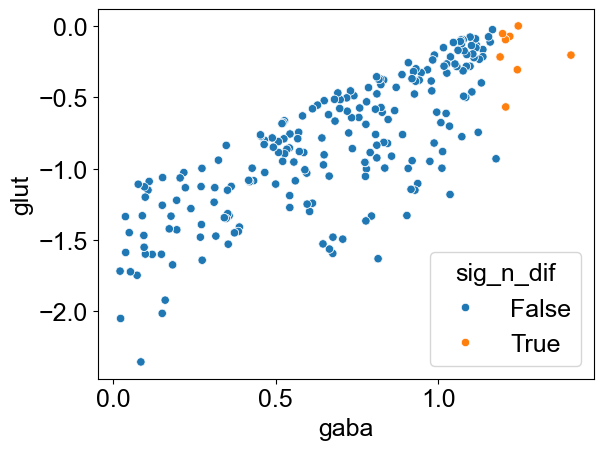

In [74]:
sns.scatterplot(x="gaba", y="glut",  data=g, hue="sig_n_dif")

### filter and plot

EPHB2
C1QB
nan
max gaba 1.5119860896557924 max_glut 0.7460811352916299


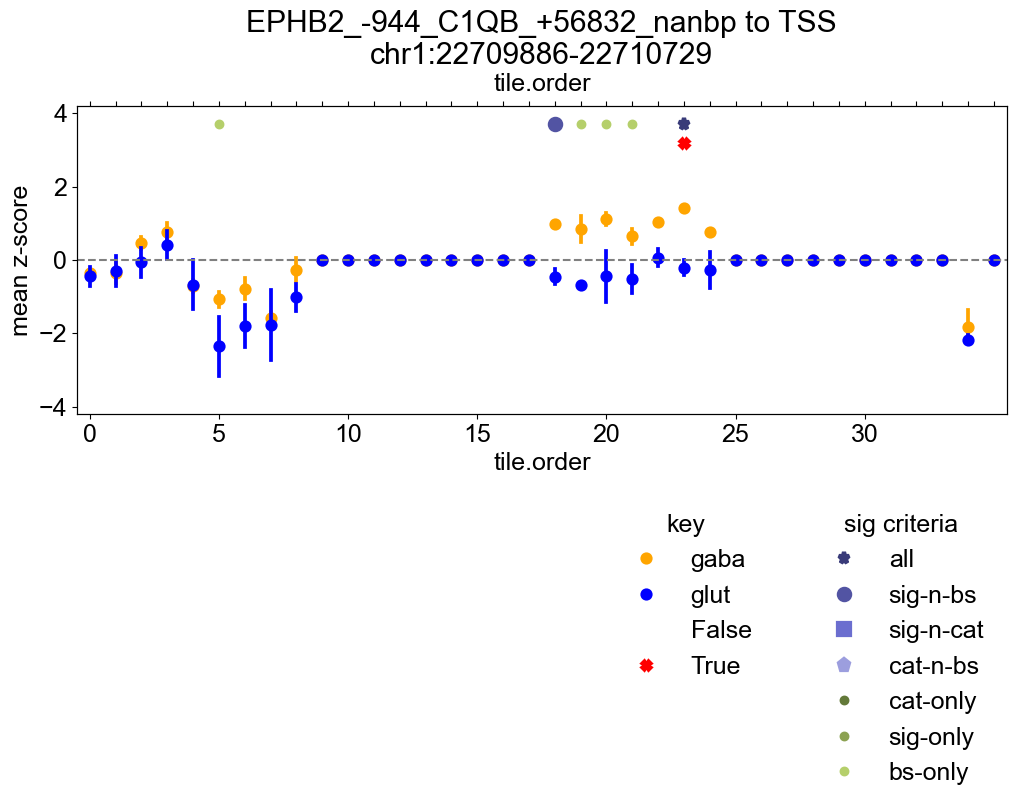

SCGB2B2
WTIP
nan
remove this tile chr19:34500241-34500511
NECAP2
NBPF1
CROCC
nan
max gaba 1.822075275669966 max_glut 2.4179710742104934


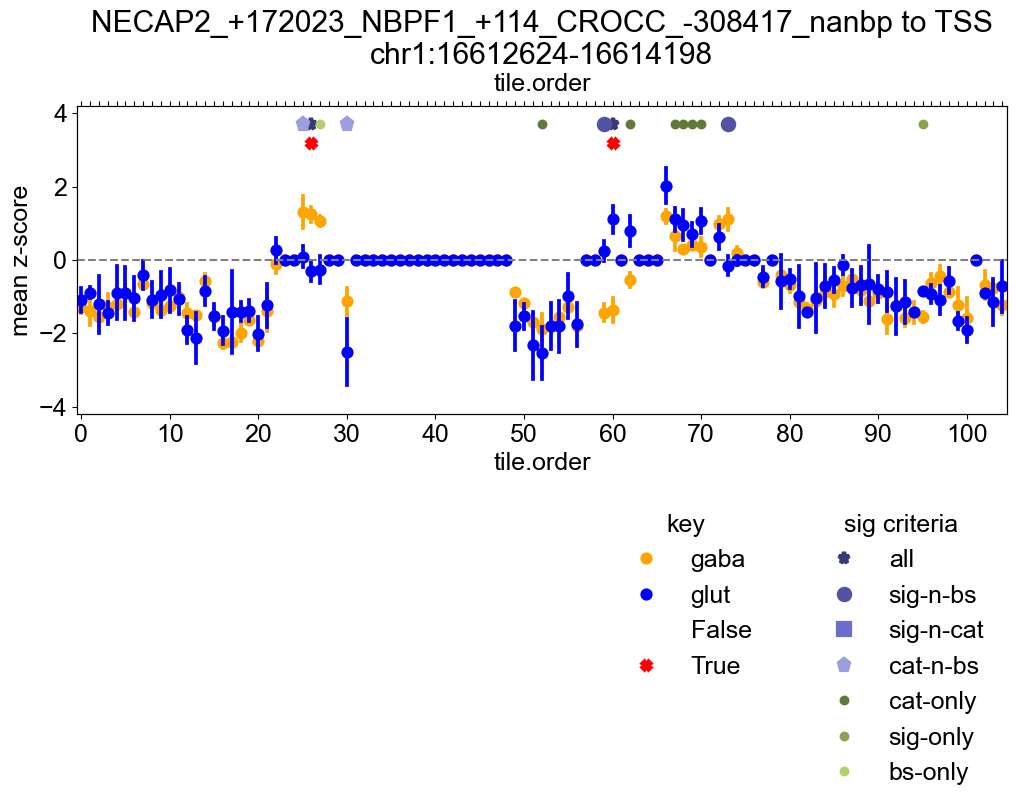

nan
max gaba 1.3420923193361285 max_glut 0.3105235209057358


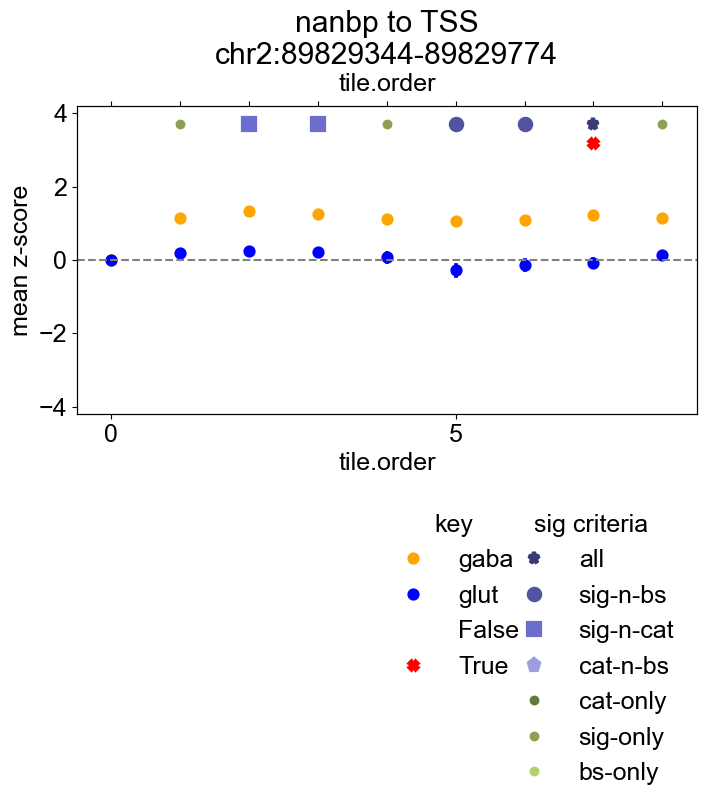

JAG2
GPR132
nan
max gaba 1.4694638401136637 max_glut 0.2019355042983563


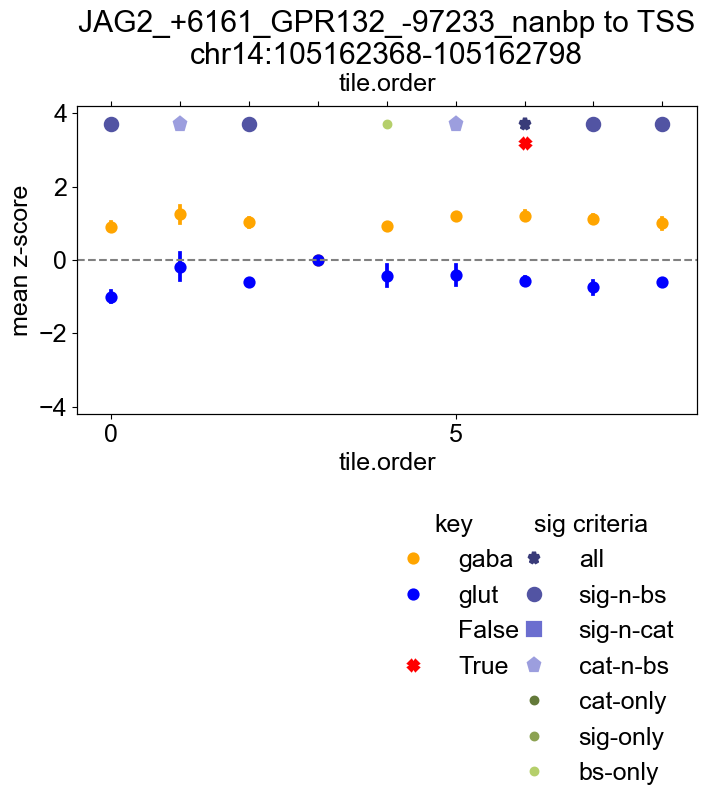

SLC2A1
ZNF691
nan
max gaba 1.3566976942149775 max_glut 1.218131603209132


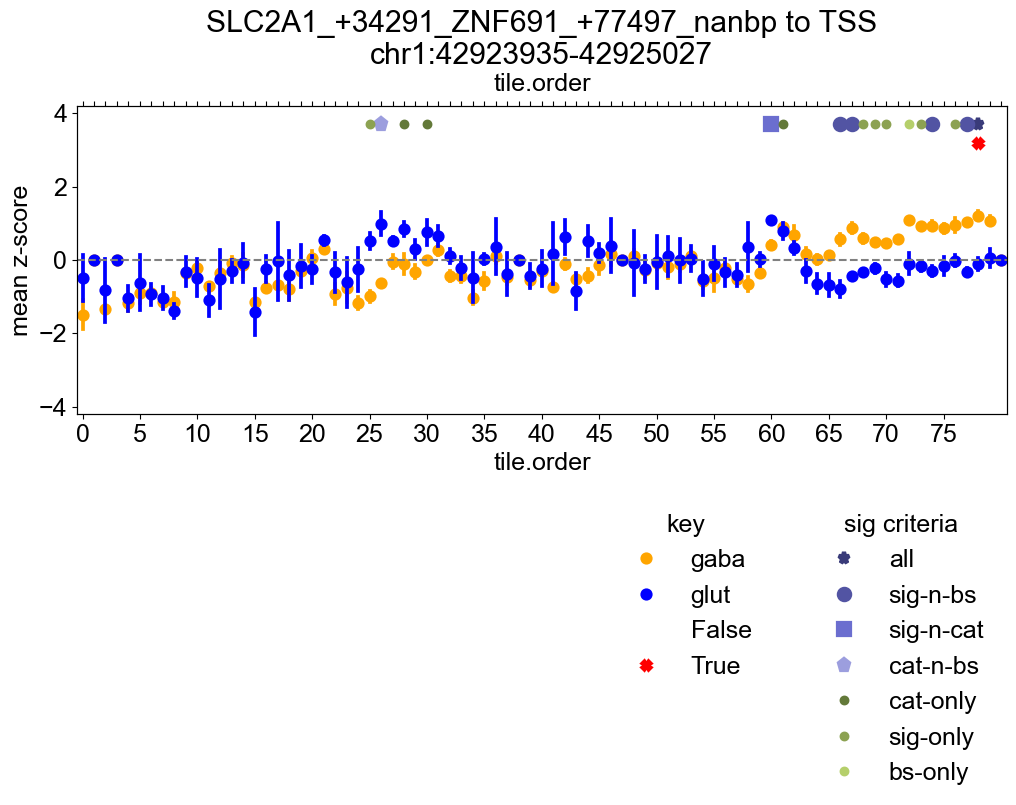

ADGRL3
nan
max gaba 1.6126681792160729 max_glut 1.1746016815172224


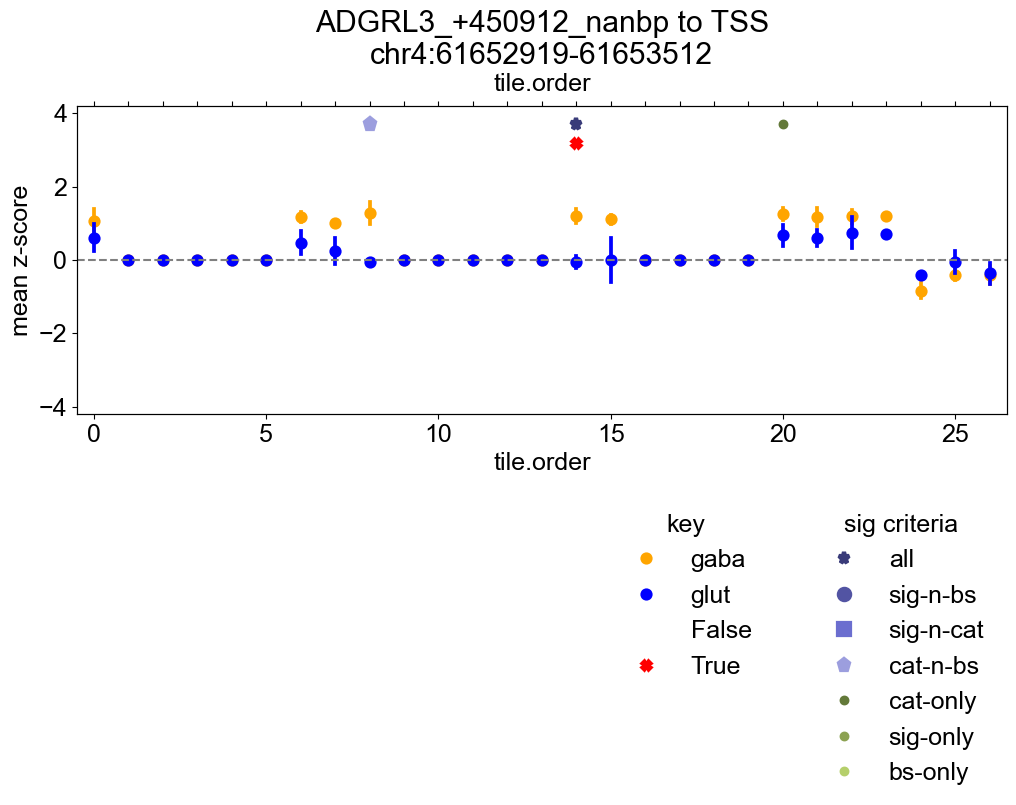

ETV4
DHX8
nan
max gaba 1.5288187188230014 max_glut 1.7047244606505954


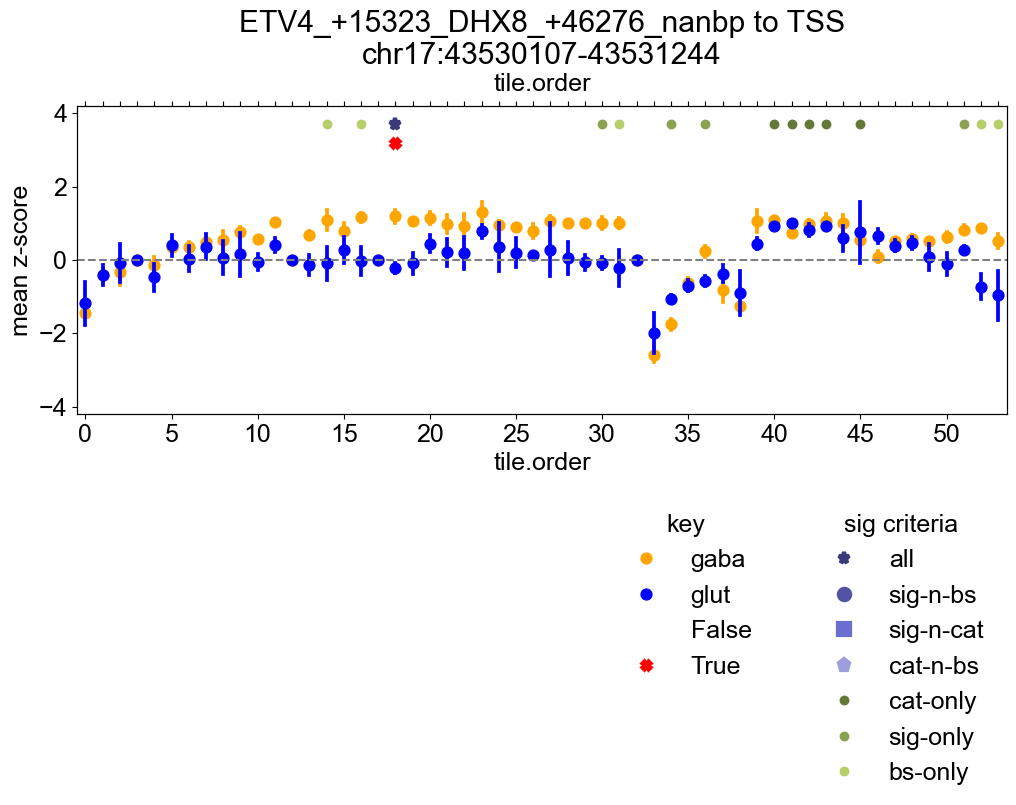

C10orf62
MORN4
PI4K2A
nan
max gaba 1.2008138632358756 max_glut 2.2025165476651227


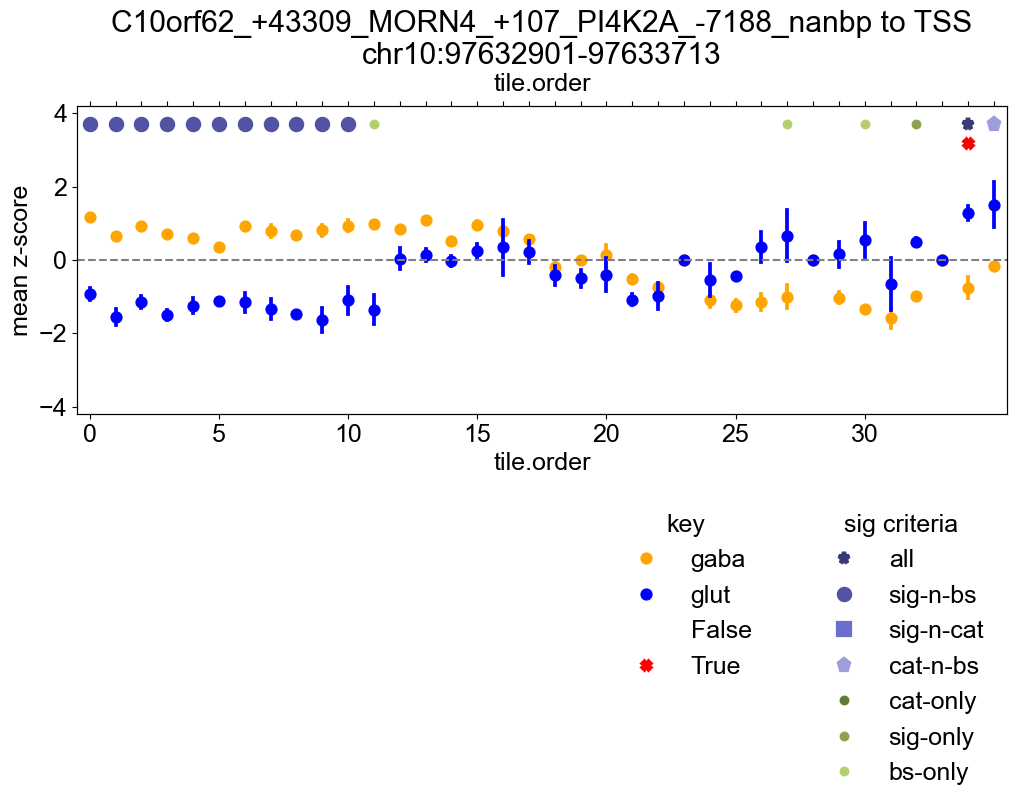

CWH43
max gaba 1.239695110389701 max_glut 0.4459169520535161


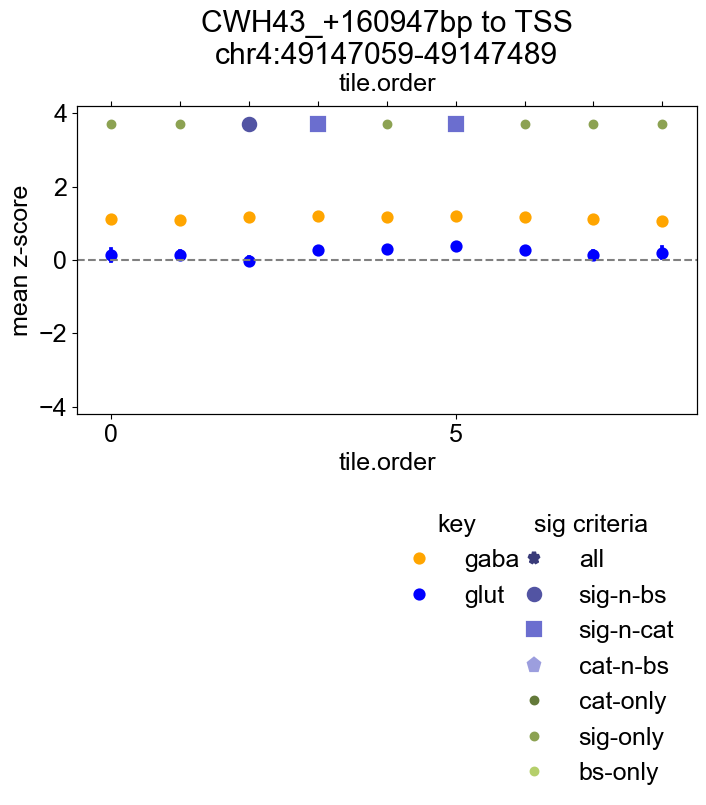

MKL1
MCHR1
nan
remove this tile chr22:40652320-40652590
CERS4
CD320
nan
CWH43
nan
PEX10
PLCH2
nan
PRICKLE3
SYP
nan
remove this tile chrX:49186369-49186639
POU3F3
nan
DSN1
SOGA1
nan
WTIP
SCGB2B2
nan
remove this tile chr19:34512408-34512678
TBC1D20
CSNK2A1
nan
LRRC6
KCNQ3
remove this tile chr8:132486279-132486549
NTMT1
PTPA
nan
remove this tile chr9:129597379-129597649
PRKD2
FKRP
STRN4
SLC1A5
nan
EXOC7
FOXJ1
nan
CFAP157
STXBP1
FAM129B
nan
MEIS2
nan
remove this tile chr15:37096031-37096301
AGMAT
DDI2
RSC1A1
nan
GCLC
ELOVL5
nan
remove this tile chr6:53359005-53359275
NTMT1
PTPA
nan
remove this tile chr9:129597399-129597669
PTRH1
CFAP157
BICC1
PHYHIPL
nan
HPS6
LDB1
nan
ENSG00000267179
ZNF763
nan
FAM184A
MCM9
nan
GLB1L2
B3GAT1
WTIP
UBA2
nan
CACNA1G
ABCC3
nan
ZMIZ1
RPS24
MCHR1
MKL1
nan
KIF5B
ARHGAP12
EPC1
nan
RASD1
PEMT
remove this tile chr17:17557088-17557358
LAMTOR4
MBLAC1
nan
PPIAL4F
NBPF15
nan
remove this tile chr1:144560579-144560849
SLC2A1
ZNF691
nan
remove this tile chr1:42957837-42958

In [86]:
TOP_N=10

df = enh.sort_values(by="gaba", ascending=False)
GABA_candidate_removal = tileLandscape(GABA_candidates, df, TOP_N, RE_MAPS, direction)

## Top glutamatergic candidates

In [88]:
ACTIVE_CL = "GLUT"
INACTIVE_CL = "GABA"
direction = f"positive {ACTIVE_CL}>negative {INACTIVE_CL}"

# get significant tiles that fall in direction
SET = getSigTileIdDirection(direction, enh, 2)

# subset dataframe and sort
candidate_cols = ["name", ACTIVE_CL.lower(), 'delta.gaba-glut', "tile.order"]

# order candidates by highest activity, greatest difference
GLUT_candidates = enh.loc[enh["name"].isin(SET), candidate_cols].drop_duplicates().sort_values(
    by=[ACTIVE_CL.lower(), 'delta.gaba-glut'], ascending=False)["name"].to_list()

print(len(GLUT_candidates))

sig_n_difcelltype_difbs
353


In [90]:
GLUT_candidates.append("chrX:49200111-49200381")

IPCEF1
OPRM1
nan
max gaba 0.9086277570744844 max_glut 4.15251451554573


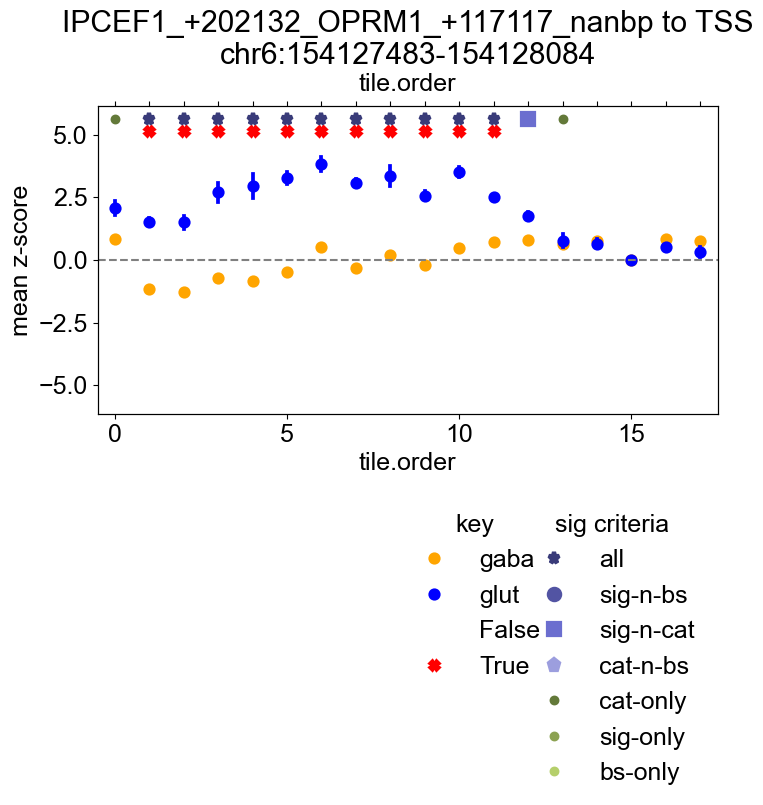

DYNC2H1
DDI1
max gaba 1.101044856787475 max_glut 2.934338910444154


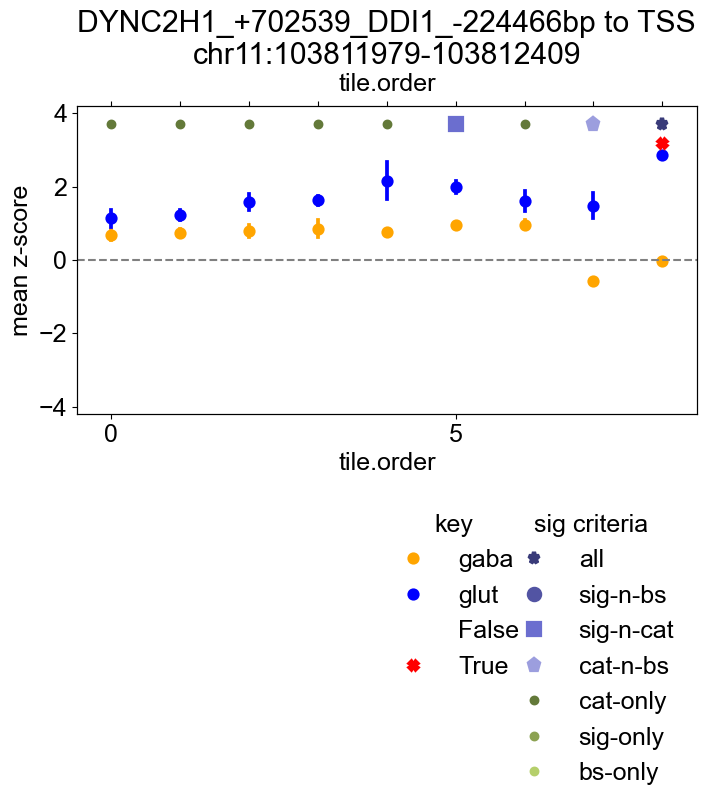

AOAH
ELMO1
max gaba 0.5441116171862074 max_glut 2.995397849733283


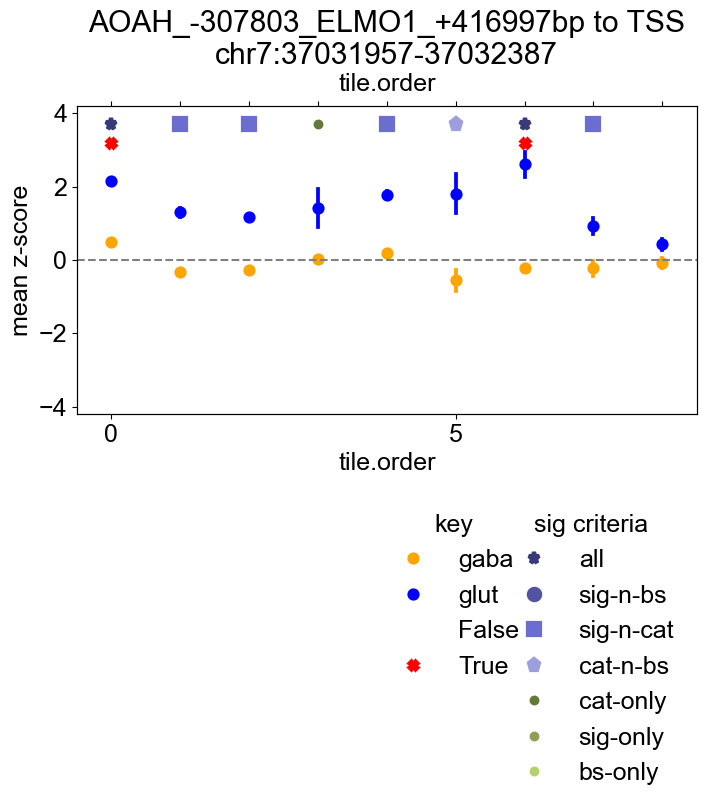

PKLR
FDPS
nan
remove this tile chr1:155308496-155308766
B3GAT1
max gaba 1.6137412701772458 max_glut 3.741051794665608


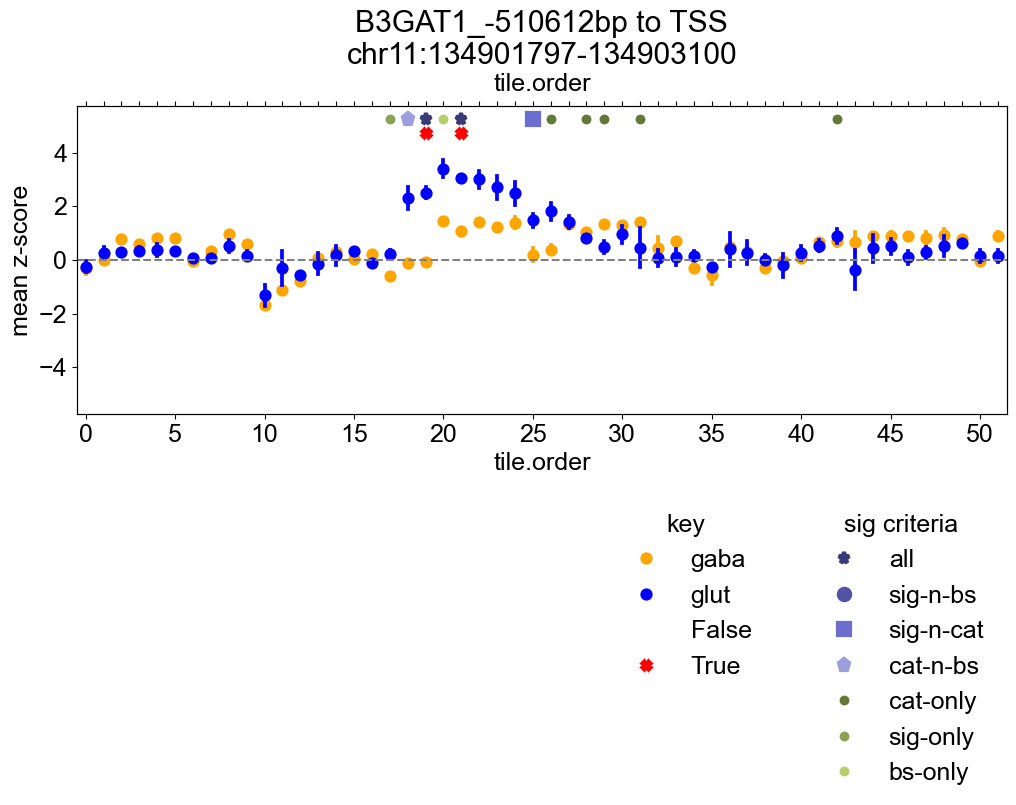

NYAP1
AGFG2
nan
max gaba 1.6197834044520494 max_glut 3.590601670880018


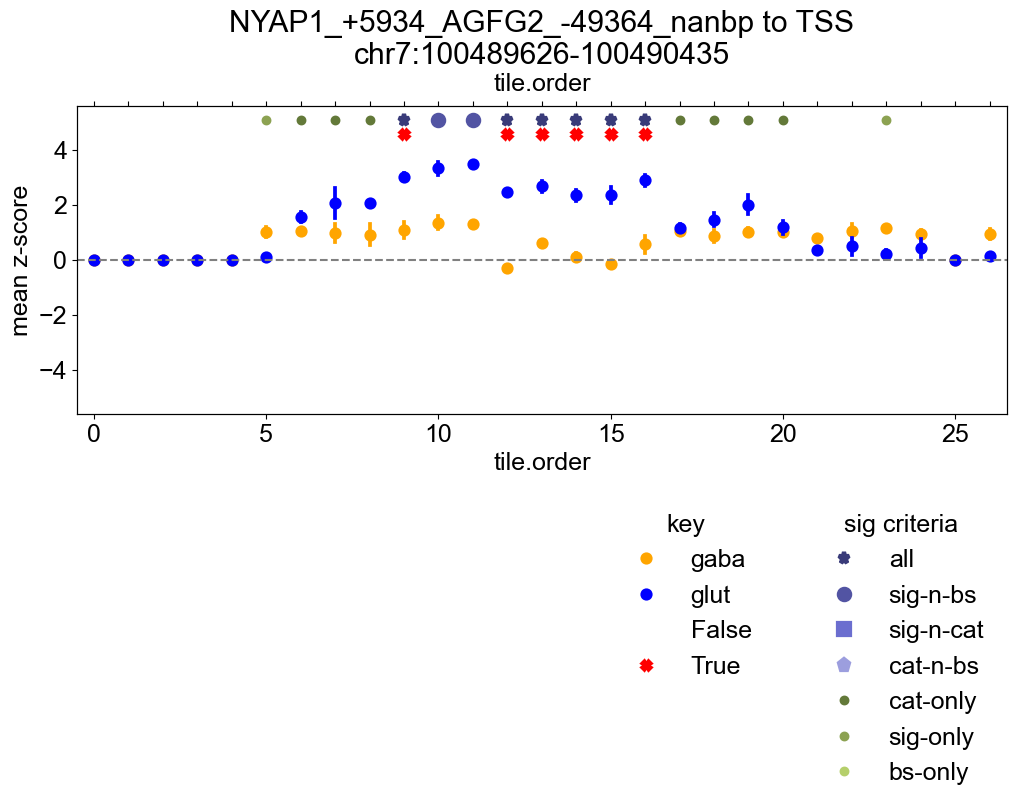

HGNC:24955
MSX2
max gaba 1.285751934063598 max_glut 4.229896981138171


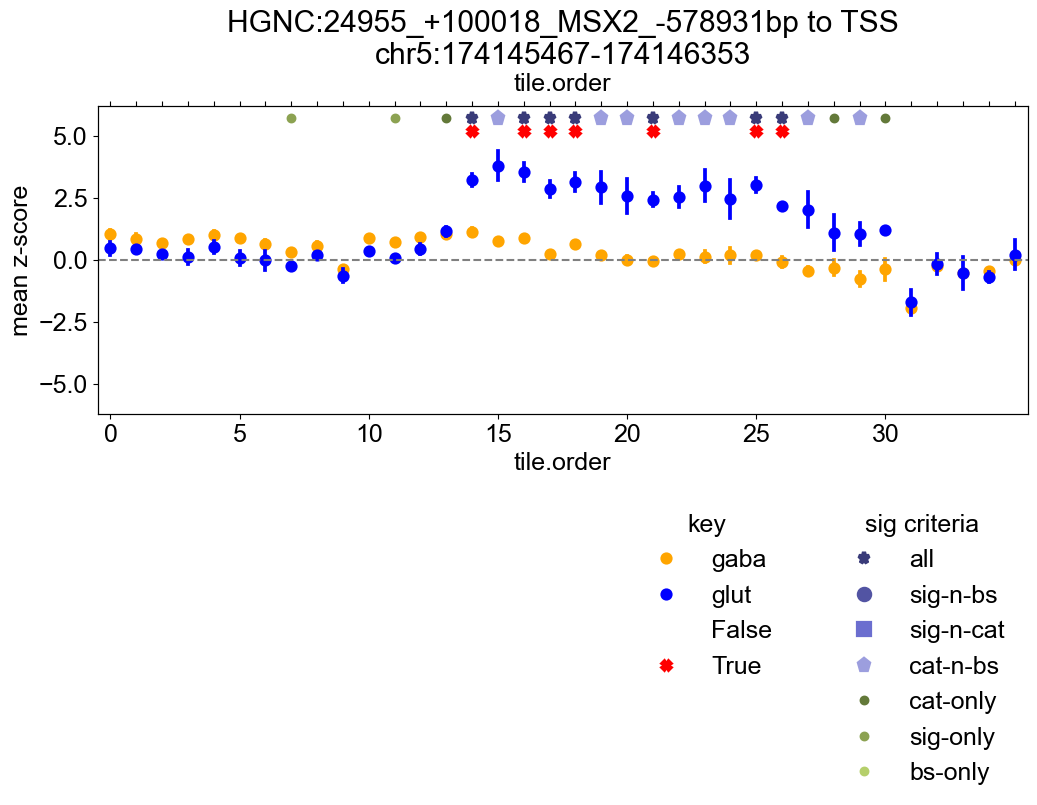

ZNF140
ZNF891
nan
max gaba 0.5086907239878102 max_glut 2.669075965661856


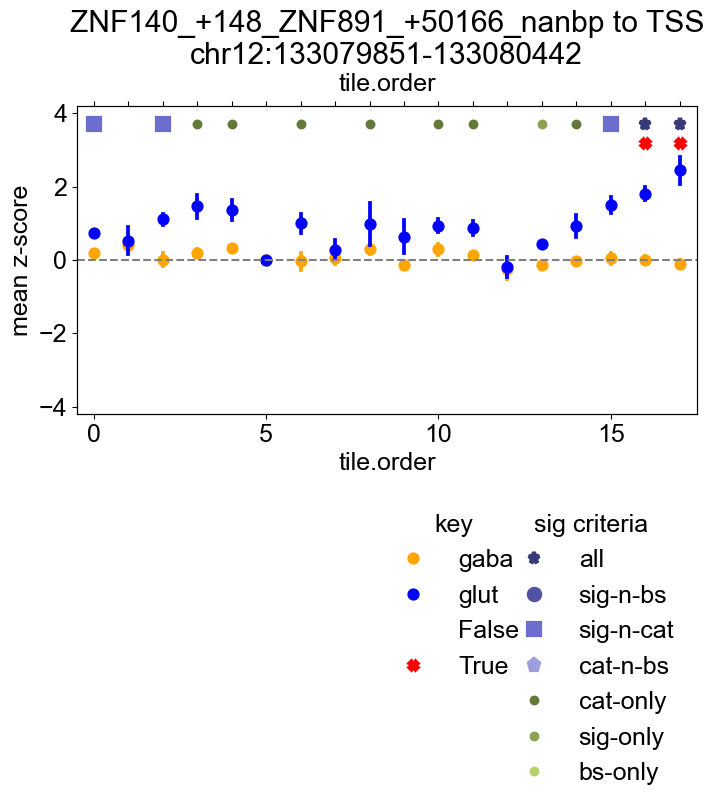

CCDC90B
max gaba 1.1606991952545702 max_glut 4.042447186790705


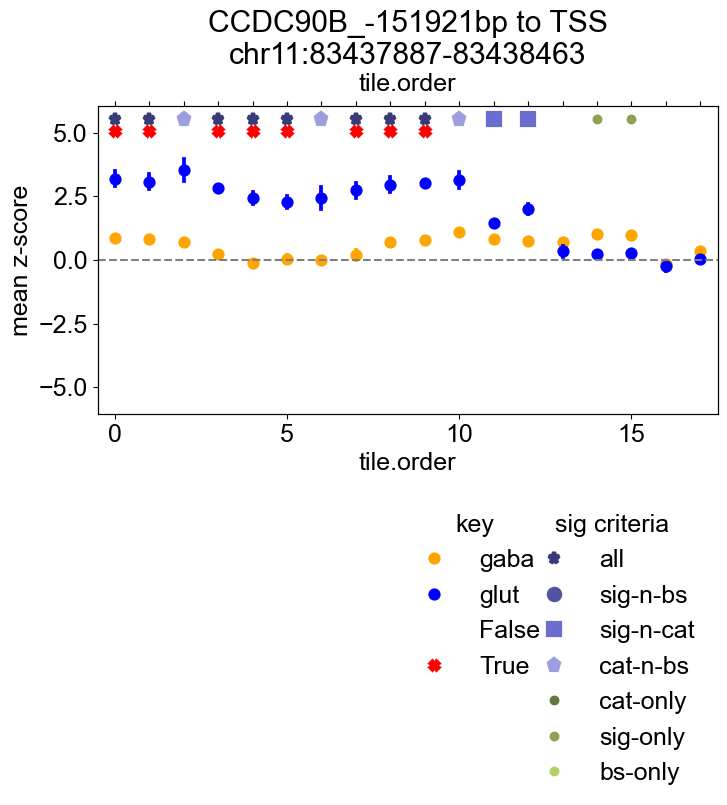

ZNF366
TNPO1
FCHO2
nan
max gaba 1.4903344082277157 max_glut 3.987498620698132


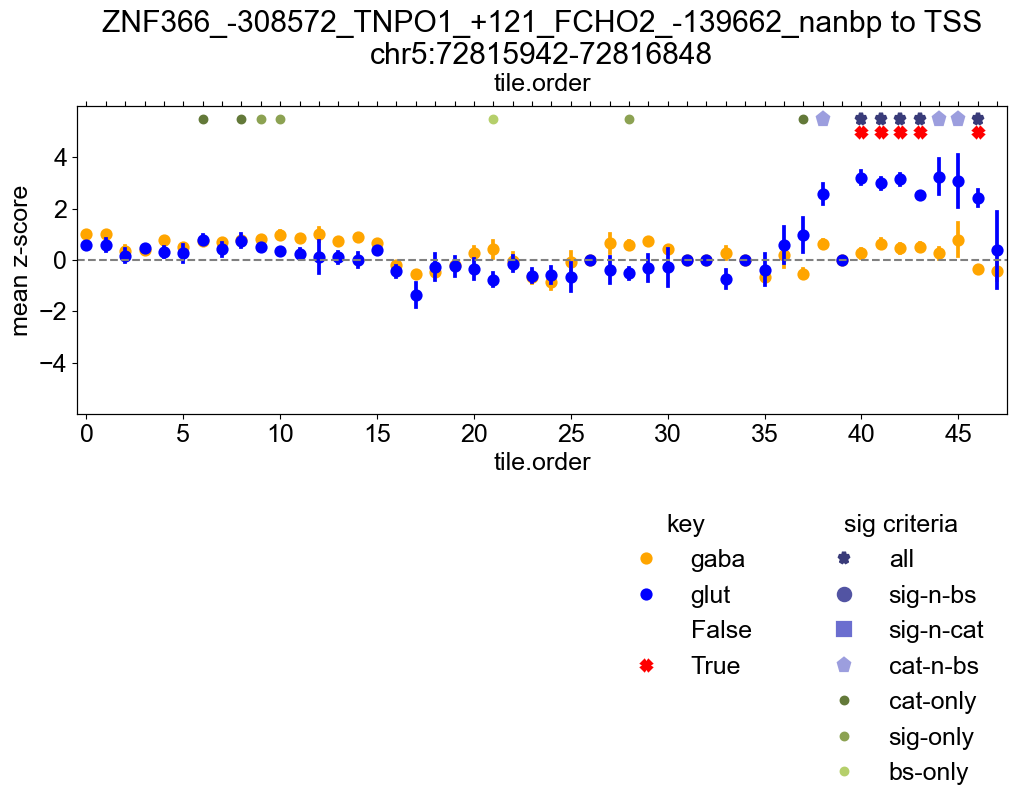

MAPK10
PTPN13
nan
GRHL2
NCALD
ST18
PCMTD1
WFIKKN2
LUC7L3
ANKRD40
nan
IER2
CACNA1A
ARCN1
PHLDB1
IFT46
nan
remove this tile chr11:118572200-118572470
ZNF584
RNF225
nan
FTCD
COL6A2
GAP43
DUSP5
SMC3
nan
remove this tile chr10:110567433-110567703
PRKAG2
GALNTL5
nan
remove this tile chr7:151888414-151888684
SERINC2
FABP3
remove this tile chr1:31376896-31377166
CDH18
HNRNPD
HNRNPDL
RASGEF1B
nan
MAZ
KIF22
nan
ST3GAL4
KIRREL3
nan
RBBP6
TNRC6A
TUBA1A
TUBA1B
nan
remove this tile chr12:49189043-49189313
NKAPL
ZSCAN26
PGBD1
nan
SHC4
EID1
GRB10
DDC
nan
GRAP2
CACNA1I
ZFP14
ZNF565
COX7A1
ZNF146
nan
CACNA1G
ABCC3
STK40
EVA1B
nan
TBC1D22A
nan
KIF1B
PGD
CTNNA2
LRRTM1
CCDC90B
PCF11
nan
MAPKAPK2
DYRK3
ZDHHC19
TFRC
nan
remove this tile chr3:196186690-196186960
MED28
DCAF16
NCAPG
nan
DNAJB12
DDIT4
THEMIS2
PPP1R8
STX12
nan
UBL4B
SLC6A17
ZNF428
ZNF576
IRGQ
ENSG00000268361
nan
SLC2A3
FOXJ2
TPRA1
PLXNA1
PEX12
AP2B1
RASL10B
nan
S100B
PRMT2
nan
EDRF1
MMP21
nan
nan
HSPA9
CTNNA1
ETF1
nan
DNER
PID1
nan
CHD2
FAM174B
n

In [91]:
TOP_N = 10
GLUT_candidate_removal = tileLandscape(GLUT_candidates, df, TOP_N, RE_MAPS, direction)

# SLC6A1, SYNGAP1

In [92]:
# start with genes and enhancer loci
BM_GENES=["SYNGAP1", "SLC6A1"]
bm_targets = set(enh.loc[(enh["gene"].isin(BM_GENES))&
                 (~enh["name"].str.contains("shuffle")), "name"])

SYNGAP1
ZBTB9
BAK1
nan
max gaba 1.489829660354376 max_glut 3.0034446961196037


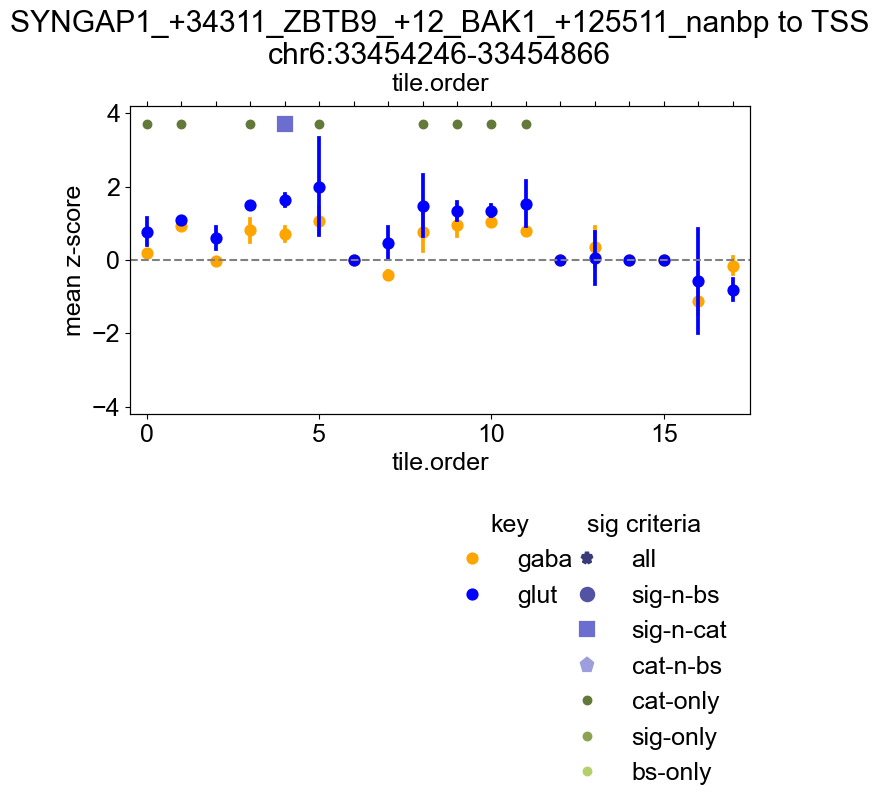

HRH1
SLC6A1
nan
max gaba 1.1392398093525904 max_glut 0.5184670356876563


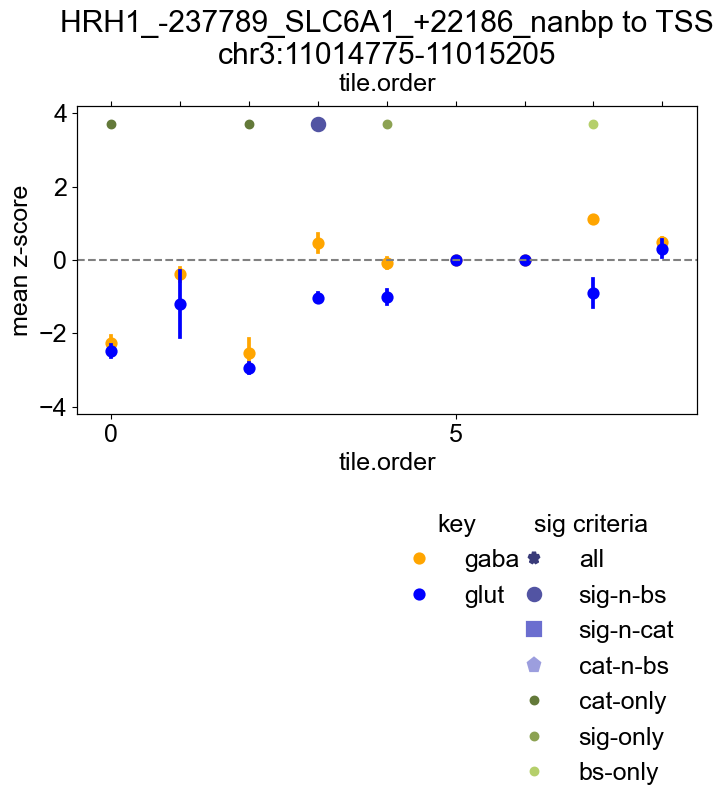

SLC6A1
HRH1
nan
remove this tile chr3:10993375-10993645
SLC6A1
HRH1
remove this tile chr3:11009355-11009625
HRH1
SLC6A1
max gaba 1.3912924689359687 max_glut 1.154184600547051


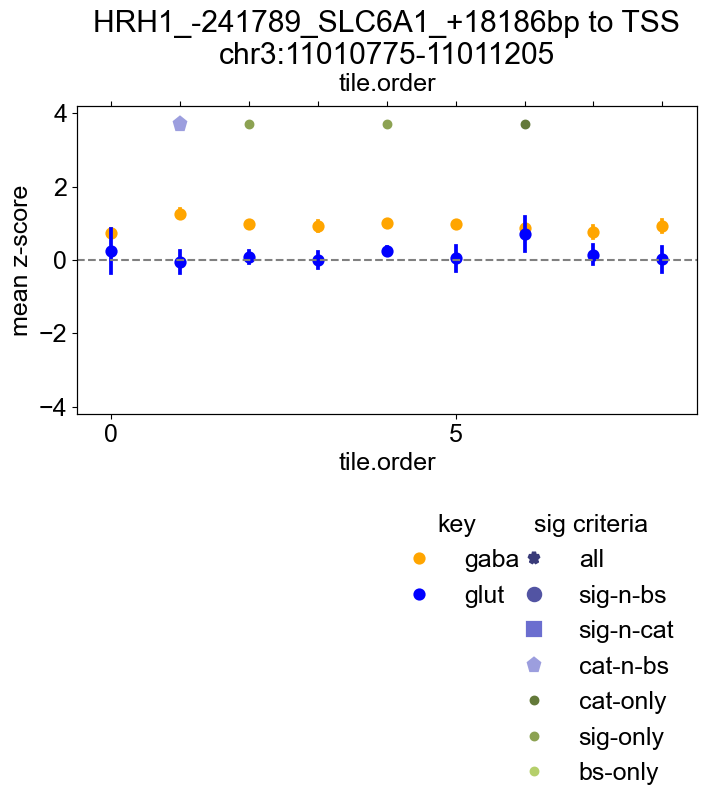

SYNGAP1
CUTA
PHF1
nan
max gaba 1.6145528549961692 max_glut 2.668363730742408


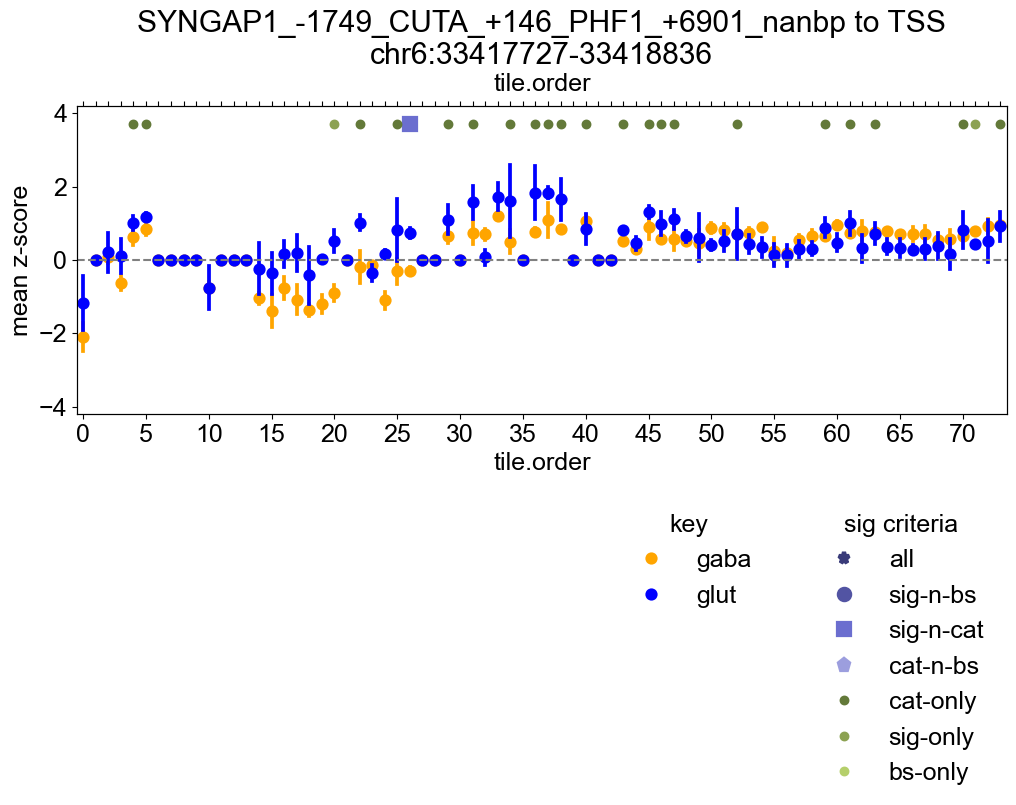

SLC6A1
SLC6A11
max gaba 1.5248751938692562 max_glut 1.5630437573260978


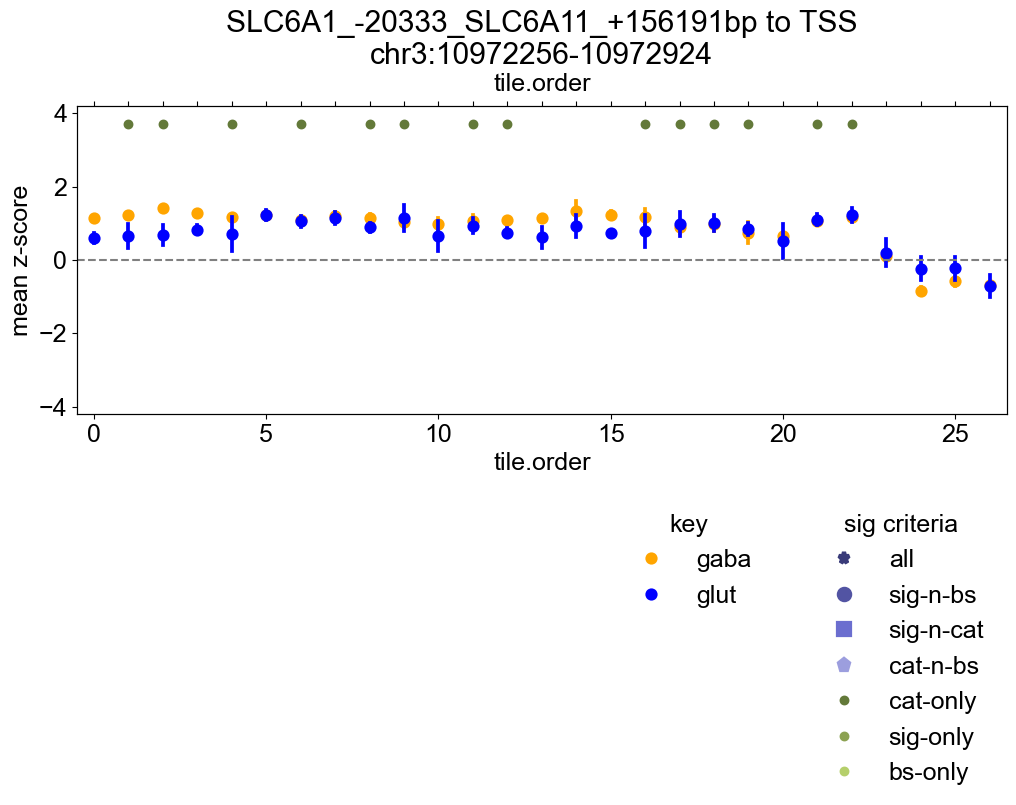

ZBTB9
SYNGAP1
nan
max gaba 1.1114904516249045 max_glut 1.9439885518880484


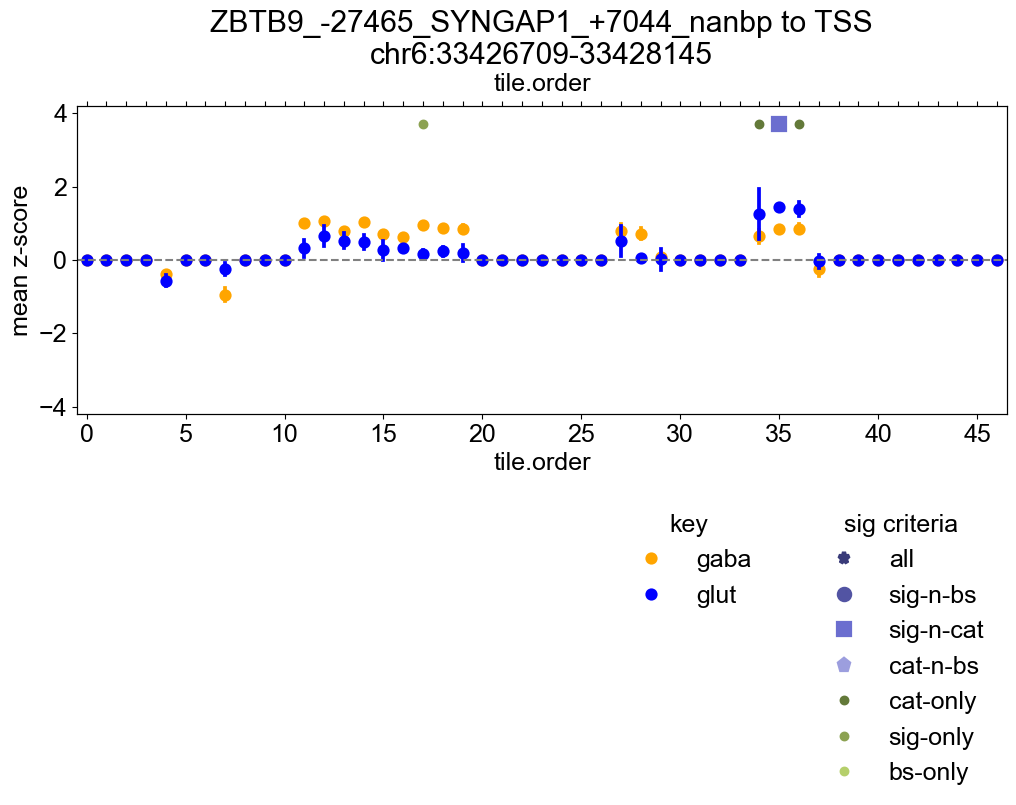

HRH1
SLC6A1
remove this tile chr3:11010275-11010545
ZBTB9
SYNGAP1
nan
max gaba 1.1399521248504576 max_glut 0.6197482088019364


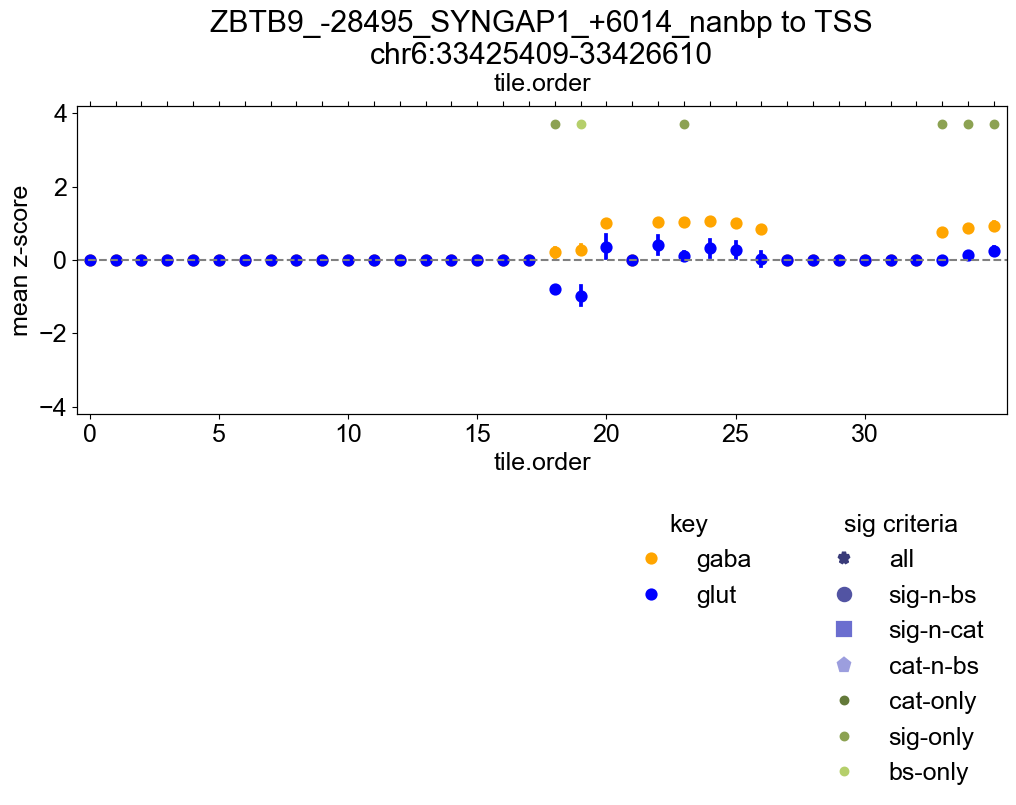

SLC6A1
HRH1
remove this tile chr3:11009915-11010185
HRH1
SLC6A1
nan
remove this tile chr3:11060965-11061235
HRH1
SLC6A1
nan
remove this tile chr3:11061150-11061420
SLC6A1
HRH1
nan
max gaba 1.2890290423025903 max_glut 2.378500802771257


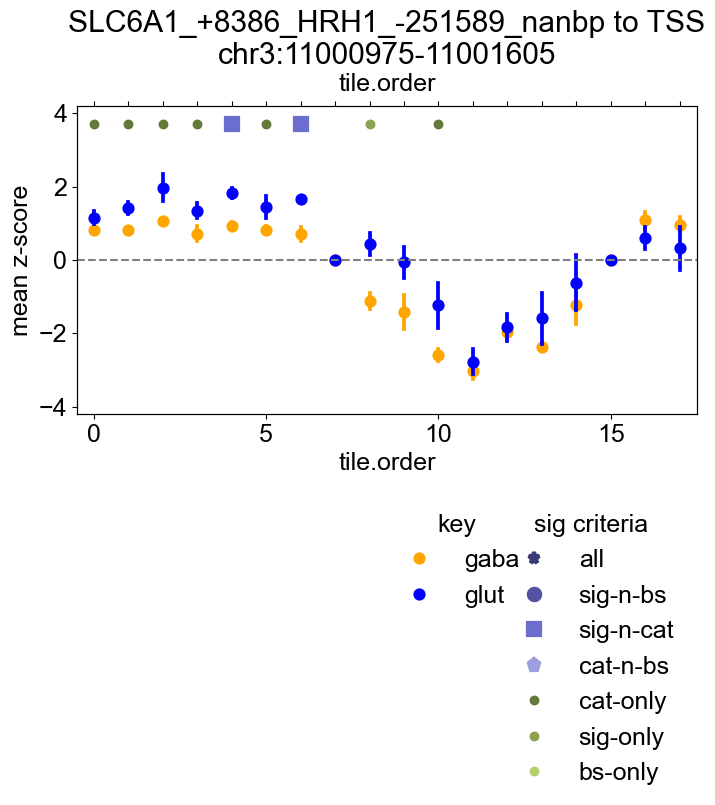

SLC6A1
HRH1
nan
remove this tile chr3:10993335-10993605
HRH1
SLC6A1
remove this tile chr3:11010375-11010645
SLC6A1
HRH1
remove this tile chr3:11009395-11009665
HRH1
SLC6A1
nan
remove this tile chr3:11061090-11061360
SLC6A1
HRH1
nan
remove this tile chr3:10993295-10993565
SLC6A1
HRH1
remove this tile chr3:11009875-11010145
HRH1
SLC6A1
nan
remove this tile chr3:11061025-11061295
SLC6A1
HRH1
remove this tile chr3:11009435-11009705
HRH1
SLC6A1
remove this tile chr3:11015335-11015605
HRH1
SLC6A1
remove this tile chr3:11015275-11015545
HRH1
SLC6A1
remove this tile chr3:11015315-11015585
SLC6A1
HRH1
remove this tile chr3:11017075-11017345
SLC6A1
HRH1
remove this tile chr3:11009815-11010085
SLC6A1
HRH1
remove this tile chr3:11009275-11009545
HRH1
SLC6A1
nan
remove this tile chr3:11060985-11061255
HRH1
SLC6A1
nan
remove this tile chr3:11061045-11061315
HRH1
SLC6A1
remove this tile chr3:11010435-11010705
SLC6A1
HRH1
remove this tile chr3:11017115-11017385
SLC6A1
HRH1
remove this tile chr3:110170

In [93]:
direction = "BM_GENES"
TOP_N = len(bm_targets) + 1
BM_candidate_removal = tileLandscape(bm_targets, df, TOP_N, RE_MAPS, direction)

# write candidates to output

## cell-type-specific

In [94]:
GABA_candidates = [item for item in GABA_candidates if item not in GABA_candidate_removal]
GLUT_candidates = [item for item in GLUT_candidates if item not in GLUT_candidate_removal]

print("removed n gaba", len(GABA_candidate_removal), "removed n glut", len(GLUT_candidate_removal))

removed n gaba 32 removed n glut 35


In [95]:
len(GABA_candidates), len(set(GLUT_candidates))

(191, 318)

## Top 10 GLUT, GABA candidates

In [96]:
candidates = [("GABA", GABA_candidates), 
              ("GLUT", GLUT_candidates), 
              ("BM", bm_targets)
             ]
  
cols = ['#chr','start.tile','end.tile',
               'candidate', 'name', 'enh.id','gene',
               'dist','direction',
               'list1', 
               'celltype_dif','bs','sig',
                'gaba','glut',
               'delta.gaba-glut',
        'gaba-label','glut-label',
               'fdr','-log10p_fdr',
               'sequence',
               ]

In [97]:
for cname, c_list in candidates:
    print(cname)
    if cname=="BM":
        candidate_dfg = enh.loc[(enh['name'].isin(c_list))].drop_duplicates()    
    else:
        candidate_dfg = enh.loc[(enh['name'].isin(c_list))].drop_duplicates()
    
    # label the candidates
    candidate_dfg.loc[candidate_dfg["name"].isin(
        c_list), "candidate"] = f"{cname}-specific"

    # if more than one sig tile per enhancer, get the max activity tile
    max_act = candidate_dfg[cols].groupby(["enh.id", "direction"])["delta.gaba-glut"].max().reset_index()
   
    candidate_dfg_max = pd.merge(max_act, candidate_dfg[cols], how="left")
    print(candidate_dfg.shape, candidate_dfg_max.shape)

    # remove any non-interesting tiles
    candidate_dfg_max = candidate_dfg_max.loc[(candidate_dfg_max['celltype_dif']==True)|
                                                #(candidate_dfg_max['bs']==True)|
                                                (candidate_dfg_max["sig"]==True)
                                                ]

    # all candidates

    # outfile
    out=os.path.join(RE, f"{cname}.specific.candidate_tiles.tsv")

    # sorting strategy - by most active
    if cname !="BM":
        candidate_dfg_max= candidate_dfg_max.sort_values(by=cname.lower(), ascending=False)
    
    else:  # or by celltype_dif
        candidate_dfg_max= candidate_dfg_max.sort_values(by="celltype_dif", ascending=False)
        candidate_dfg_max= candidate_dfg_max.loc[candidate_dfg_max["gene"].isin(BM_GENES)]

    # write
    candidate_dfg_max[cols].to_csv(out, sep='\t', index=False)
    print(len(set(candidate_dfg_max['name'])))

    # proximal candidates - those within 10kb of gene, regardless of max activity
    out_10kb=os.path.join(RE, f"{cname}.specific.10kb.candidate_tiles.tsv")

    # remove elements wo gene mapping
    gene_annotated = candidate_dfg.loc[~(candidate_dfg["dist"].isna())].copy()

    # remove any non-interesting tiles
    gene_annotated = gene_annotated.loc[(gene_annotated['celltype_dif']==True)|
                                                #(gene_annotated['bs']==True)|
                                                (gene_annotated["sig"]==True)
                                                ]

    
    
    # write 10kb
    gene_annotated.loc[(gene_annotated["dist"].map(int)>0)&
                (gene_annotated["dist"].map(int)<10000),
                cols].sort_values(by="celltype_dif", ascending=False).to_csv(out_10kb, sep='\t', index=False)


GABA
(358, 44) (172, 21)
92
GLUT
(615, 44) (320, 21)
167
BM
(420, 44) (90, 21)
13


# tfbs archetypes

In [ ]:
ARCH = os.path.join(PATH, "tfbs_archetypes", "biomarin-lib2-hg38-final.x.vierstra.archetypes.cleaned.re-intersect.lib1.bed")

In [ ]:
names=["#chr", "start.tile", "end.tile", "id", "#chr.arch", "start.arch", "end.arch", "arch_name", 'strand', "score"]
arch =pd.read_csv(ARCH, sep='\t', header=None, names=names)
arch["name"] = arch["#chr"] + ":" + arch["start.tile"].map(str) + "-" + arch["end.tile"].map(str)
arch.head()

In [ ]:
arch_df = pd.merge(df[["name", "candidate"]], arch[["name", "arch_name"]]).drop_duplicates()


In [ ]:
arch_df["dummy"] = 1
arch_df.head()

In [ ]:
arch_count = arch_df.groupby(["candidate", "arch_name"])["name"].count().reset_index()

In [ ]:
top20GABA=set(arch_count.loc[arch_count["candidate"].str.contains('GABA')].sort_values(by="name", ascending=False).head(10)['arch_name'])

In [ ]:

arch_count.loc[arch_count["candidate"].str.contains('GABA')].sort_values(by="name", ascending=False).head(20)

In [ ]:
top20GLUT=set(arch_count.loc[arch_count["candidate"].str.contains('GLUT')].sort_values(by="name", ascending=False).head(10)['arch_name'])

In [ ]:
# gluts
top20GLUT.difference(top20GABA)

In [ ]:
# gluts
top20GABA.difference(top20GLUT)

In [ ]:
arch_count.loc[arch_count["candidate"].str.contains('GLUT')].sort_values(by="name", ascending=False).head(20)

## pivot table

In [ ]:
gabatf = arch_df.loc[arch_df["candidate"].str.contains('GABA')]

In [ ]:
pd.pivot(gabatf, 
         index="name", columns="arch_name", values="dummy")